In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 401 ms, sys: 2.93 ms, total: 404 ms
Wall time: 453 ms


In [ ]:
# This function is adapted from ScatterCorrHist, provided above, and adds hue
def ScatterCorrHistHue(df, target):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corrdot_num = len(kwargs['labels'])
    corrdot_spacing = 1 / corrdot_num
    corrdot_idx, = np.where(kwargs['labels'] == kwargs['label'])[0]
    corrdot_pos = corrdot_spacing / 2 + corrdot_idx * corrdot_spacing
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000 / corrdot_num   # marker size
    fsz = abs(corr_r) * 40 / corrdot_num + 5 # font size
    ax.scatter([corrdot_pos], [.5], msz, color=kwargs['color'], alpha=0.5, transform=ax.transAxes)
    ax.annotate(corr_text, [corrdot_pos, .5,], xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, hue=target, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.scatterplot);
  g.map_diag(sns.histplot, kde=True);
  g.map_upper(corrdot, labels=np.sort(transactions['is_fraud'].unique()));
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

In [ ]:
transactions = pd.read_csv('/content/drive/MyDrive/transactions.csv', index_col=0); transactions.head(1)

trans_date_trans_time            cc_num                    merchant  \
0   2019-01-01 00:00:18  2703186189652095  fraud_Rippin, Kub and Mann   

   category   amt     first   last sex          street            city  ...  \
0  misc_net  4.97  Jennifer  Banks   F  561 Perry Cove  Moravian Falls  ...   

     lat   long  city_pop                        job         dob  \
0  36.08 -81.18      3495  Psychologist, counselling  1988-03-09   

                          trans_num   unix_time merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018     36.01      -82.05   

   is_fraud  
0         0  

[1 rows x 22 columns]

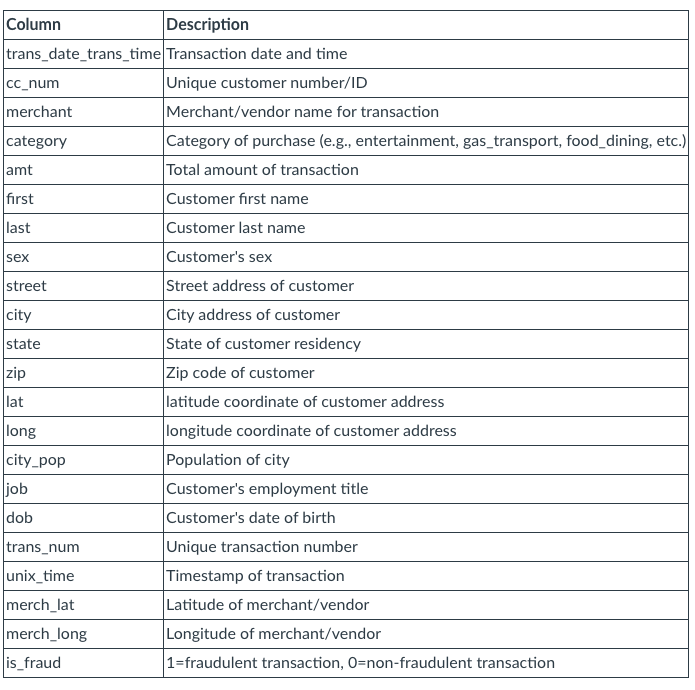

# DATA

In [ ]:
len(transactions['cc_num'].unique())

999

In [ ]:
transactions.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'sex', 'street', 'city', 'state', 'zip', 'lat', 'long',
       'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'age', 'age_group', 'victim_identifier',
       'average_transactions_per_day', 'bin', 'time', 'timedecimal',
       'datetime', 'day_of_week', 'month'],
      dtype='object')

In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   sex                    object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

In [ ]:
# Print name, type, and unique entries or number of entries for each feature

def unique_entries(tXY):
  print(f'{"Column Name":<16s}{"Type":<11s}Unique Entries')
  for col in tXY.columns:
      unique = tXY[col].unique()
      if len(unique) < 10:
          print(f'{col:<16s}{str(tXY[col].dtype):<11s}{np.sort(unique)}')
      else:
          print(f'{col:<16s}{str(tXY[col].dtype):<11s}{len(unique)} unique entries')

unique_entries(transactions)

Column Name     Type       Unique Entries
trans_date_trans_timeobject     1819551 unique entries
cc_num          int64      999 unique entries
merchant        object     693 unique entries
category        object     14 unique entries
amt             float64    60616 unique entries
first           object     355 unique entries
last            object     486 unique entries
sex             object     ['F' 'M']
street          object     999 unique entries
city            object     906 unique entries
state           object     51 unique entries
zip             int64      985 unique entries
lat             float64    983 unique entries
long            float64    983 unique entries
city_pop        int64      891 unique entries
job             object     497 unique entries
dob             object     984 unique entries
trans_num       object     1852394 unique entries
unix_time       int64      1819583 unique entries
merch_lat       float64    1754157 unique entries
merch_long      float64   

In [ ]:
def find_null_values(df):
    print(f'{"Column Name":<16s}{"Null values":<11s}')
    null_counts = df.isnull().sum()
    null_columns = null_counts[null_counts > 0]
    if not null_columns.empty:

        for col, null_count in null_columns.items():
            print(f"{col}, {null_count}")
    else:
        print("No null values found in any column.")

# Assuming 'df' is your DataFrame
find_null_values(transactions)


Column Name     Null values
No null values found in any column.


In [ ]:
# Iterate through each column in the DataFrame
def duplicates(df):
  for col in df.columns:
      # Find duplicate values in the column
      duplicates = df[col][df[col].duplicated()]

      # Print column name and number of duplicate values
      print(f'{col}, {len(duplicates)}')
duplicates(transactions)


trans_date_trans_time, 32843
cc_num, 1851395
merchant, 1851701
category, 1852380
amt, 1791778
first, 1852039
last, 1851908
sex, 1852392
street, 1851395
city, 1851488
state, 1852343
zip, 1851409
lat, 1851411
long, 1851411
city_pop, 1851503
job, 1851897
dob, 1851410
trans_num, 0
unix_time, 32811
merch_lat, 98237
merch_long, 42641
is_fraud, 1852392


In [ ]:
do_eda=False

# Co-Relations

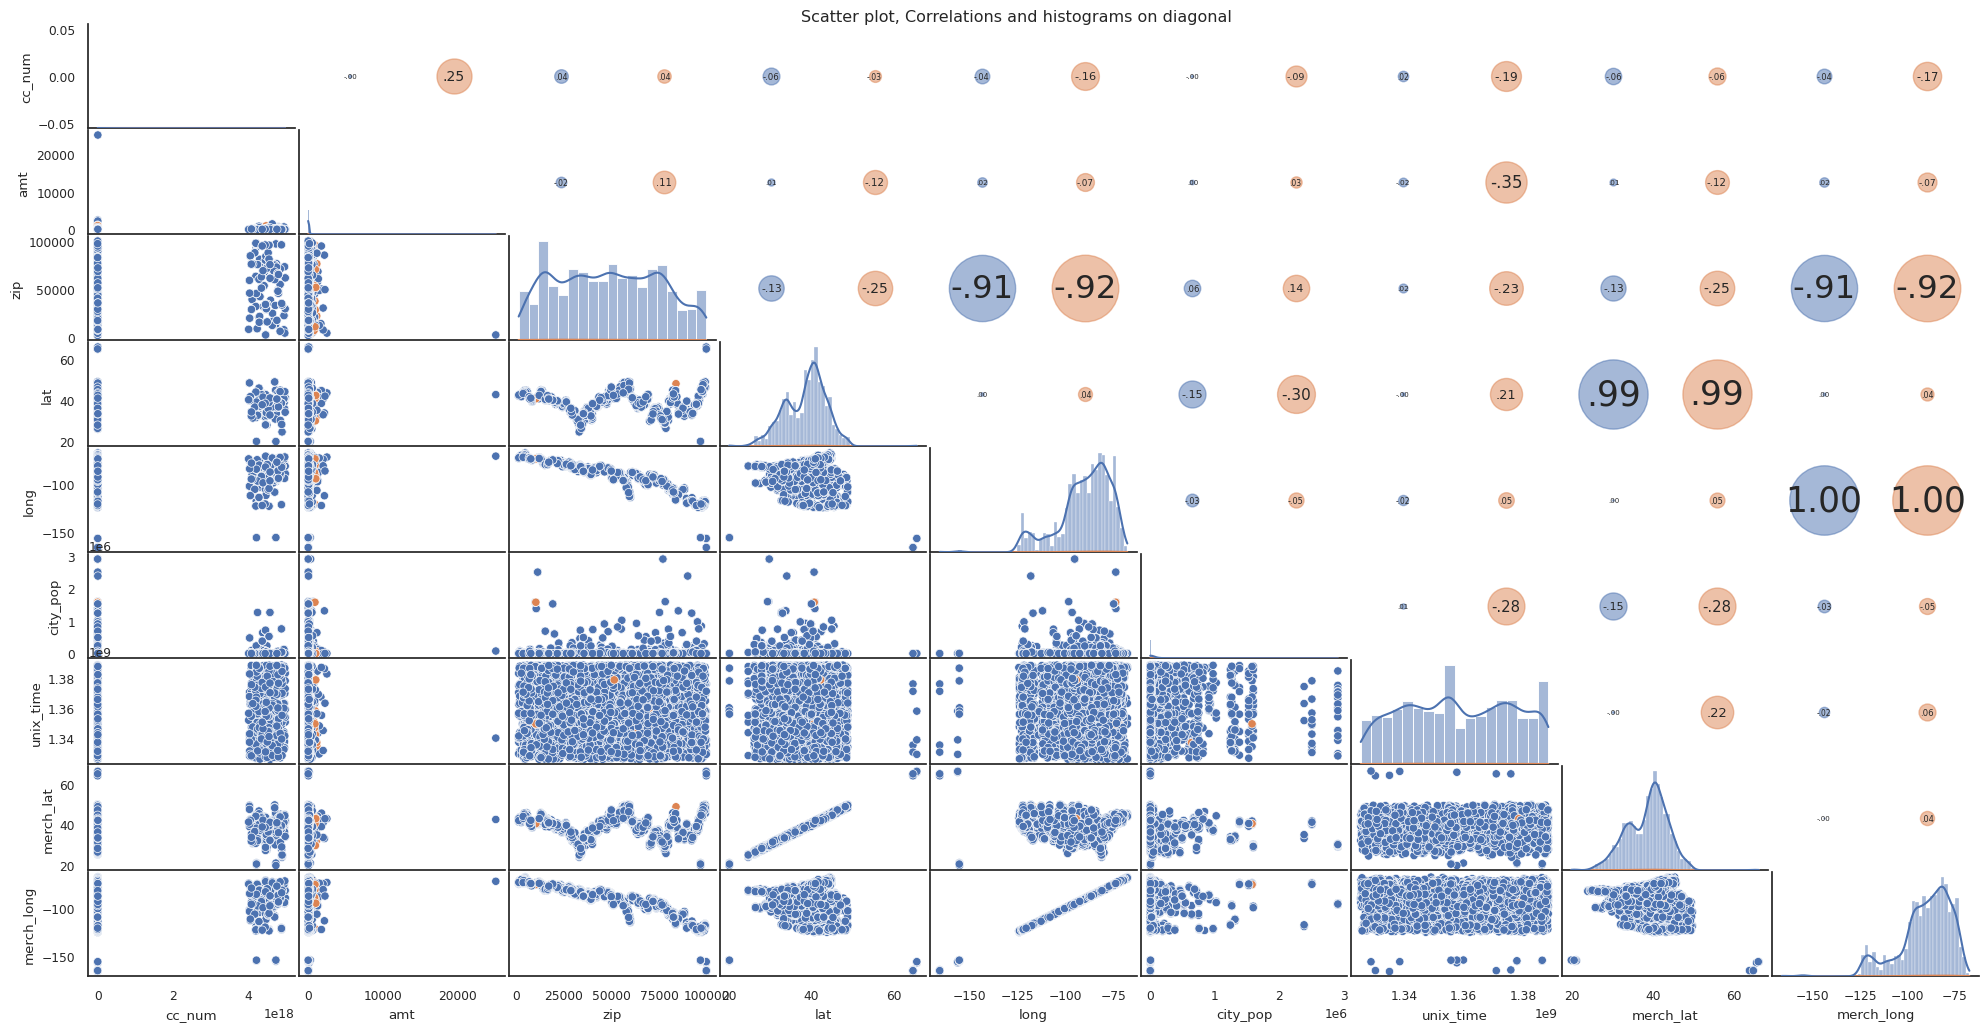

In [ ]:
if do_eda:
  eda_sample = transactions.select_dtypes(include=['int', 'float']).sample(n=5000, random_state=7) # Subsample for EDA
  ScatterCorrHistHue(eda_sample, 'is_fraud')

![scatter_plot.png](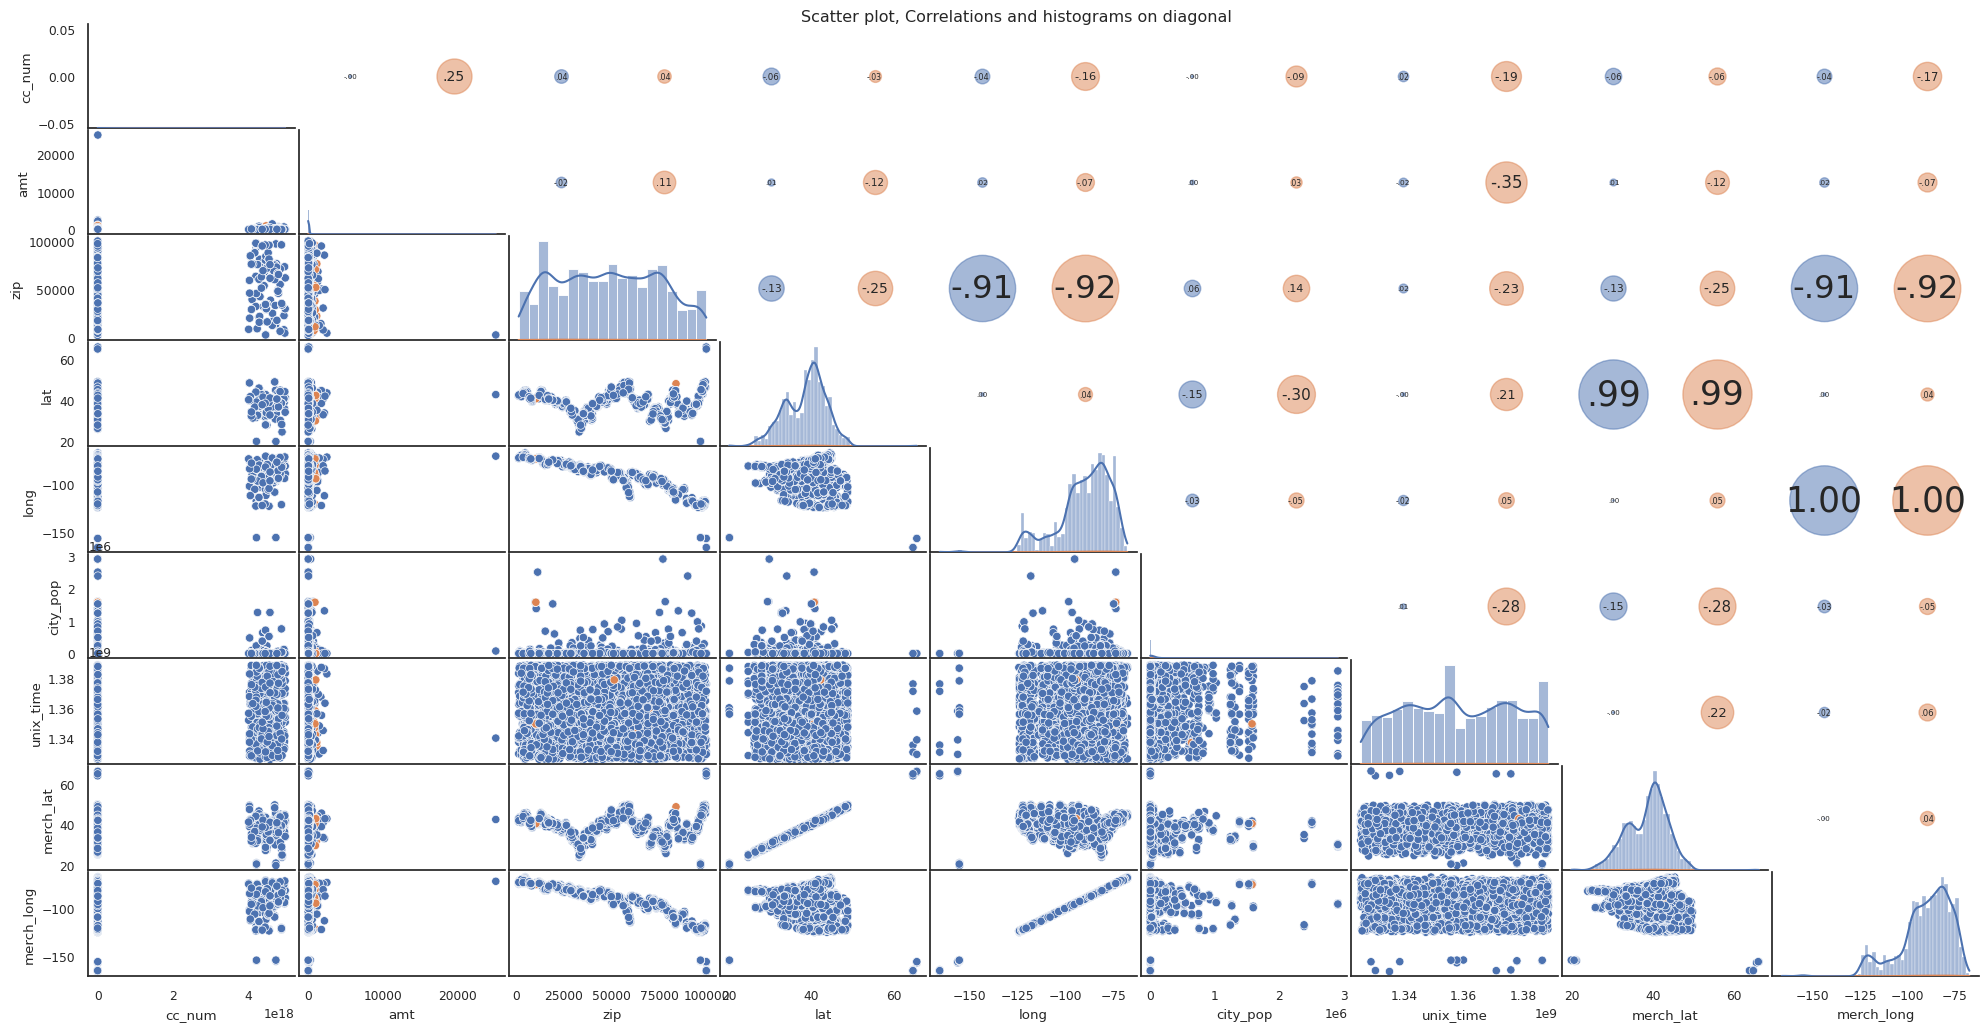![scatter_plot-2.png](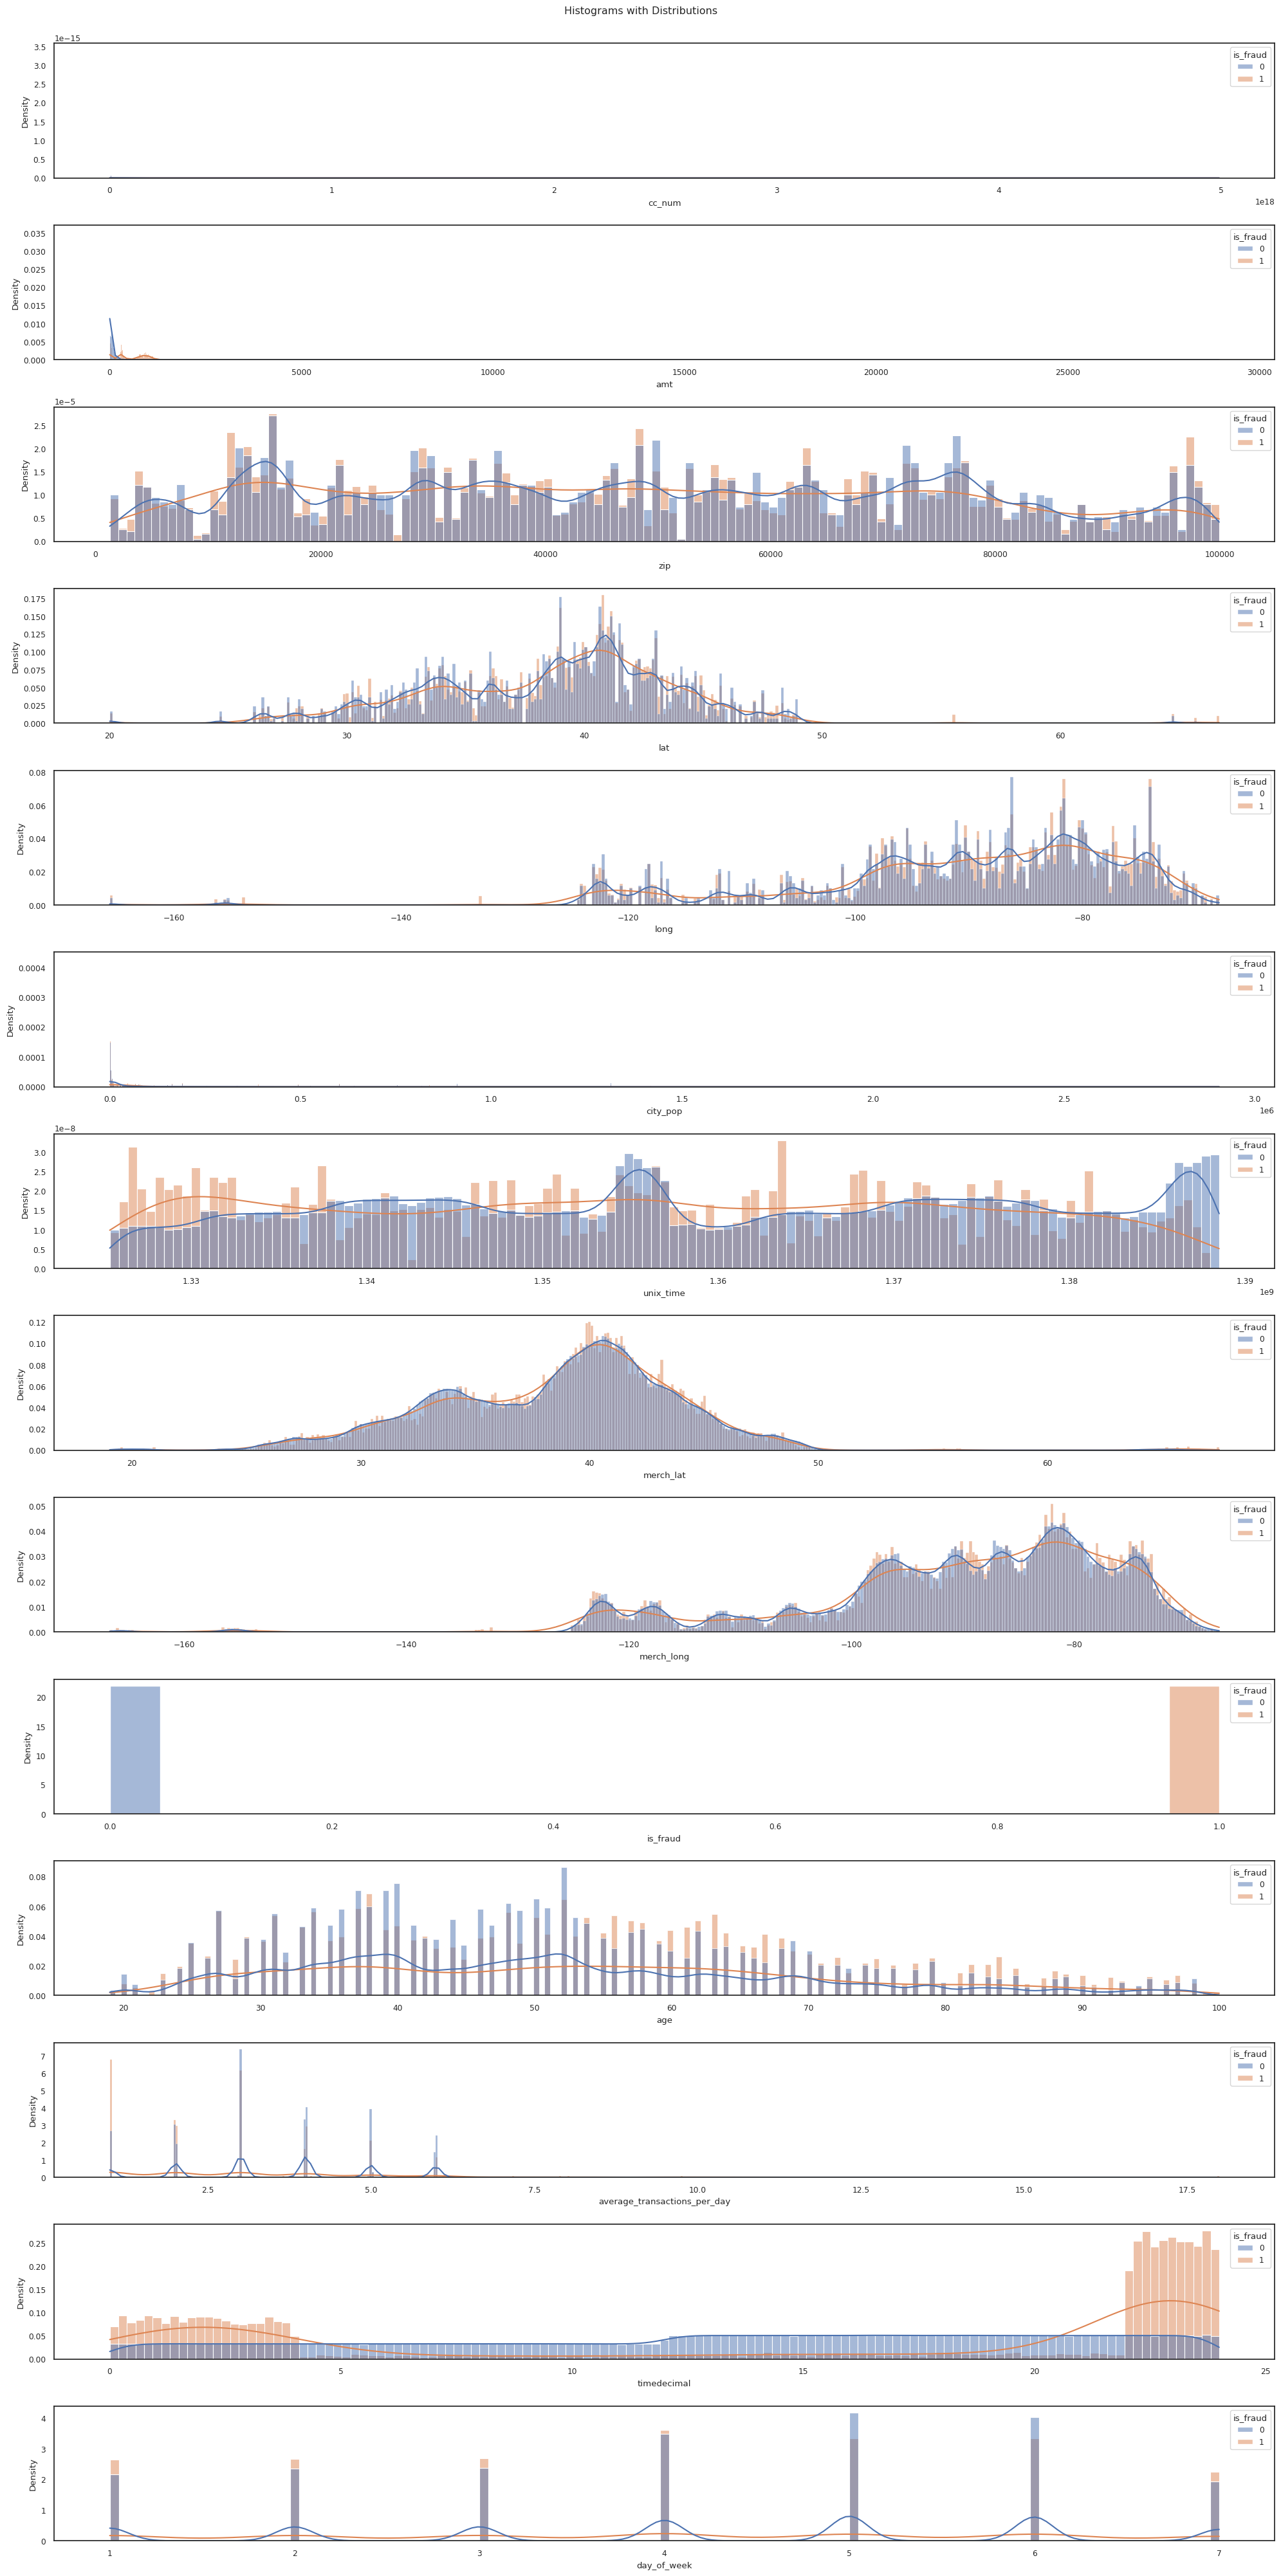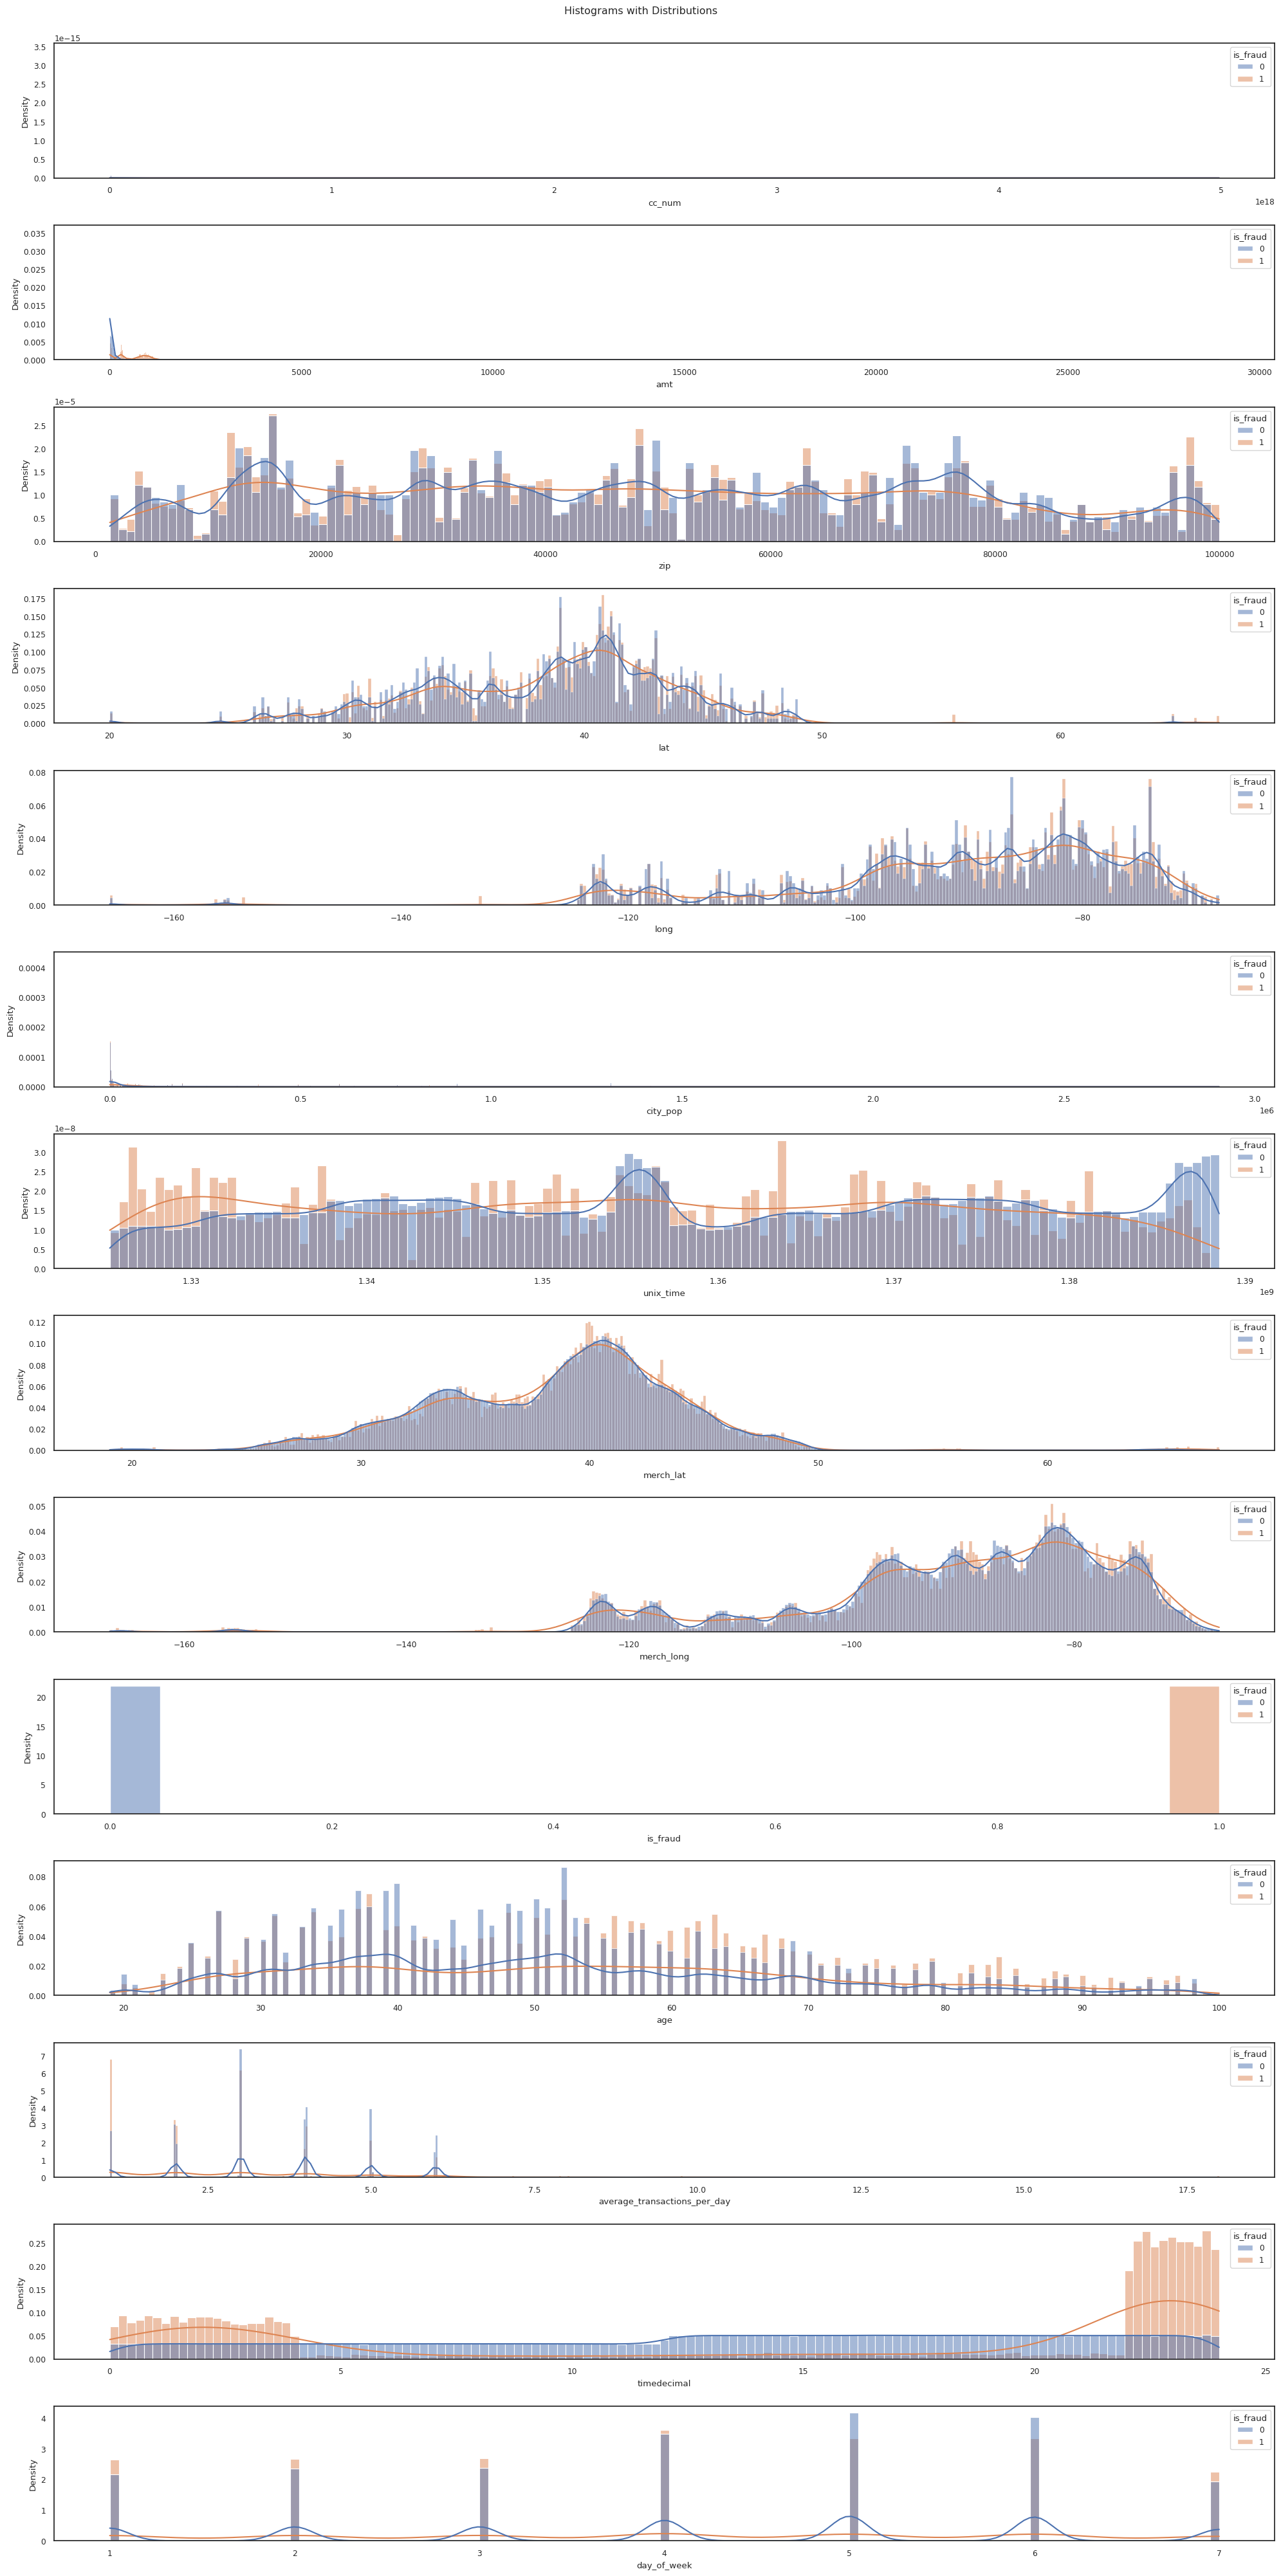))

# Box Plots

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def Boxplots(df):
  # Get number and list of numerical features
  num_numerical = sum([pd.api.types.is_numeric_dtype(df[col]) for col in df.columns])
  numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

  # Set up figure
  fig = make_subplots(rows=1, cols=num_numerical)

  # Make plots
  for i in range(num_numerical):
    feature = numerical_features[i]
    fig.add_trace(go.Box(y=df[feature], name=feature), row=1, col=i+1)
  fig.update_layout(title_text="Interactive Boxplots", showlegend=False)
  fig.show()

if do_eda:
  Boxplots(transactions)

# Histograms

In [ ]:
# This function is adapted from ScatterCorrHist, provided above, to work with
# categorical features
def HistKde(df, target):
  # Get number and list of numerical features
  num_numerical = sum([pd.api.types.is_numeric_dtype(df[col]) for col in df.columns])
  numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

  # Set up figure
  sns.set(style='white', font_scale=.8);
  fig, axes = plt.subplots(num_numerical, 1)
  fig.set_size_inches(20,40)

  # Make plots
  for i in range(num_numerical):
    feature = numerical_features[i]
    # credit: https://stackoverflow.com/questions/34615854
    sns.histplot(df, x=feature, hue=target, kde=True, stat='density', common_norm=False, ax=axes[i])
  fig.suptitle('Histograms with Distributions', y=1);
  plt.tight_layout()
  _ = plt.show();
  #ifdo_eda:
  #HistKde(tXY, 'Class')

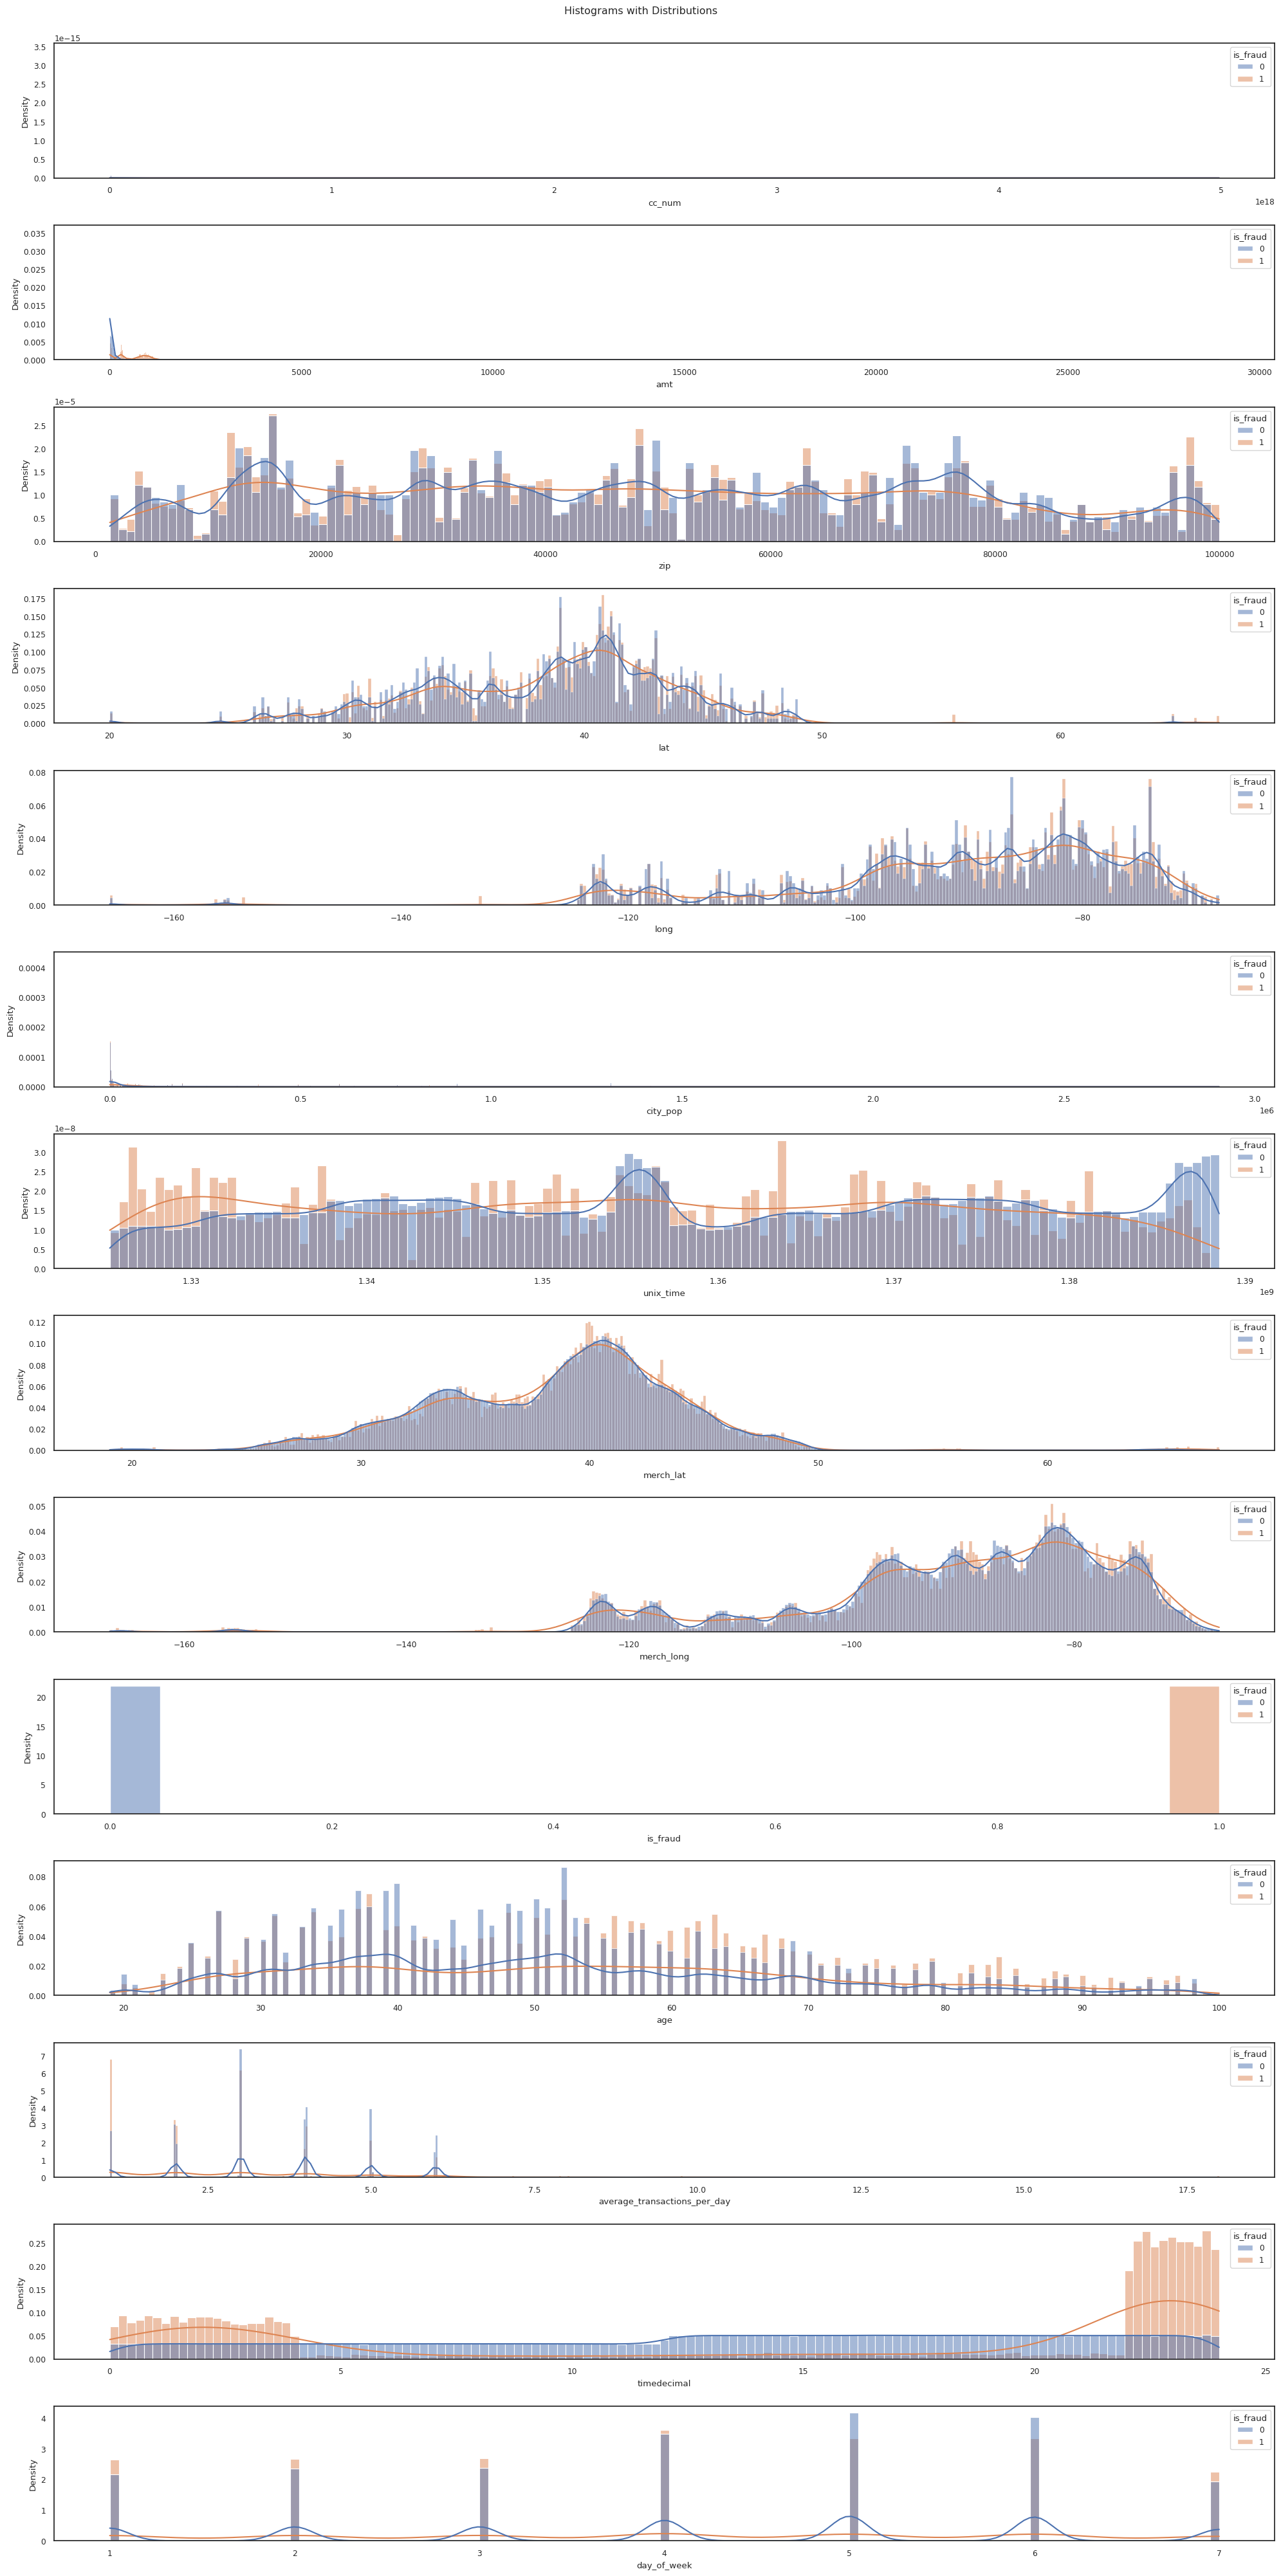

In [ ]:
 if do_eda:
  HistKde(transactions, 'is_fraud')

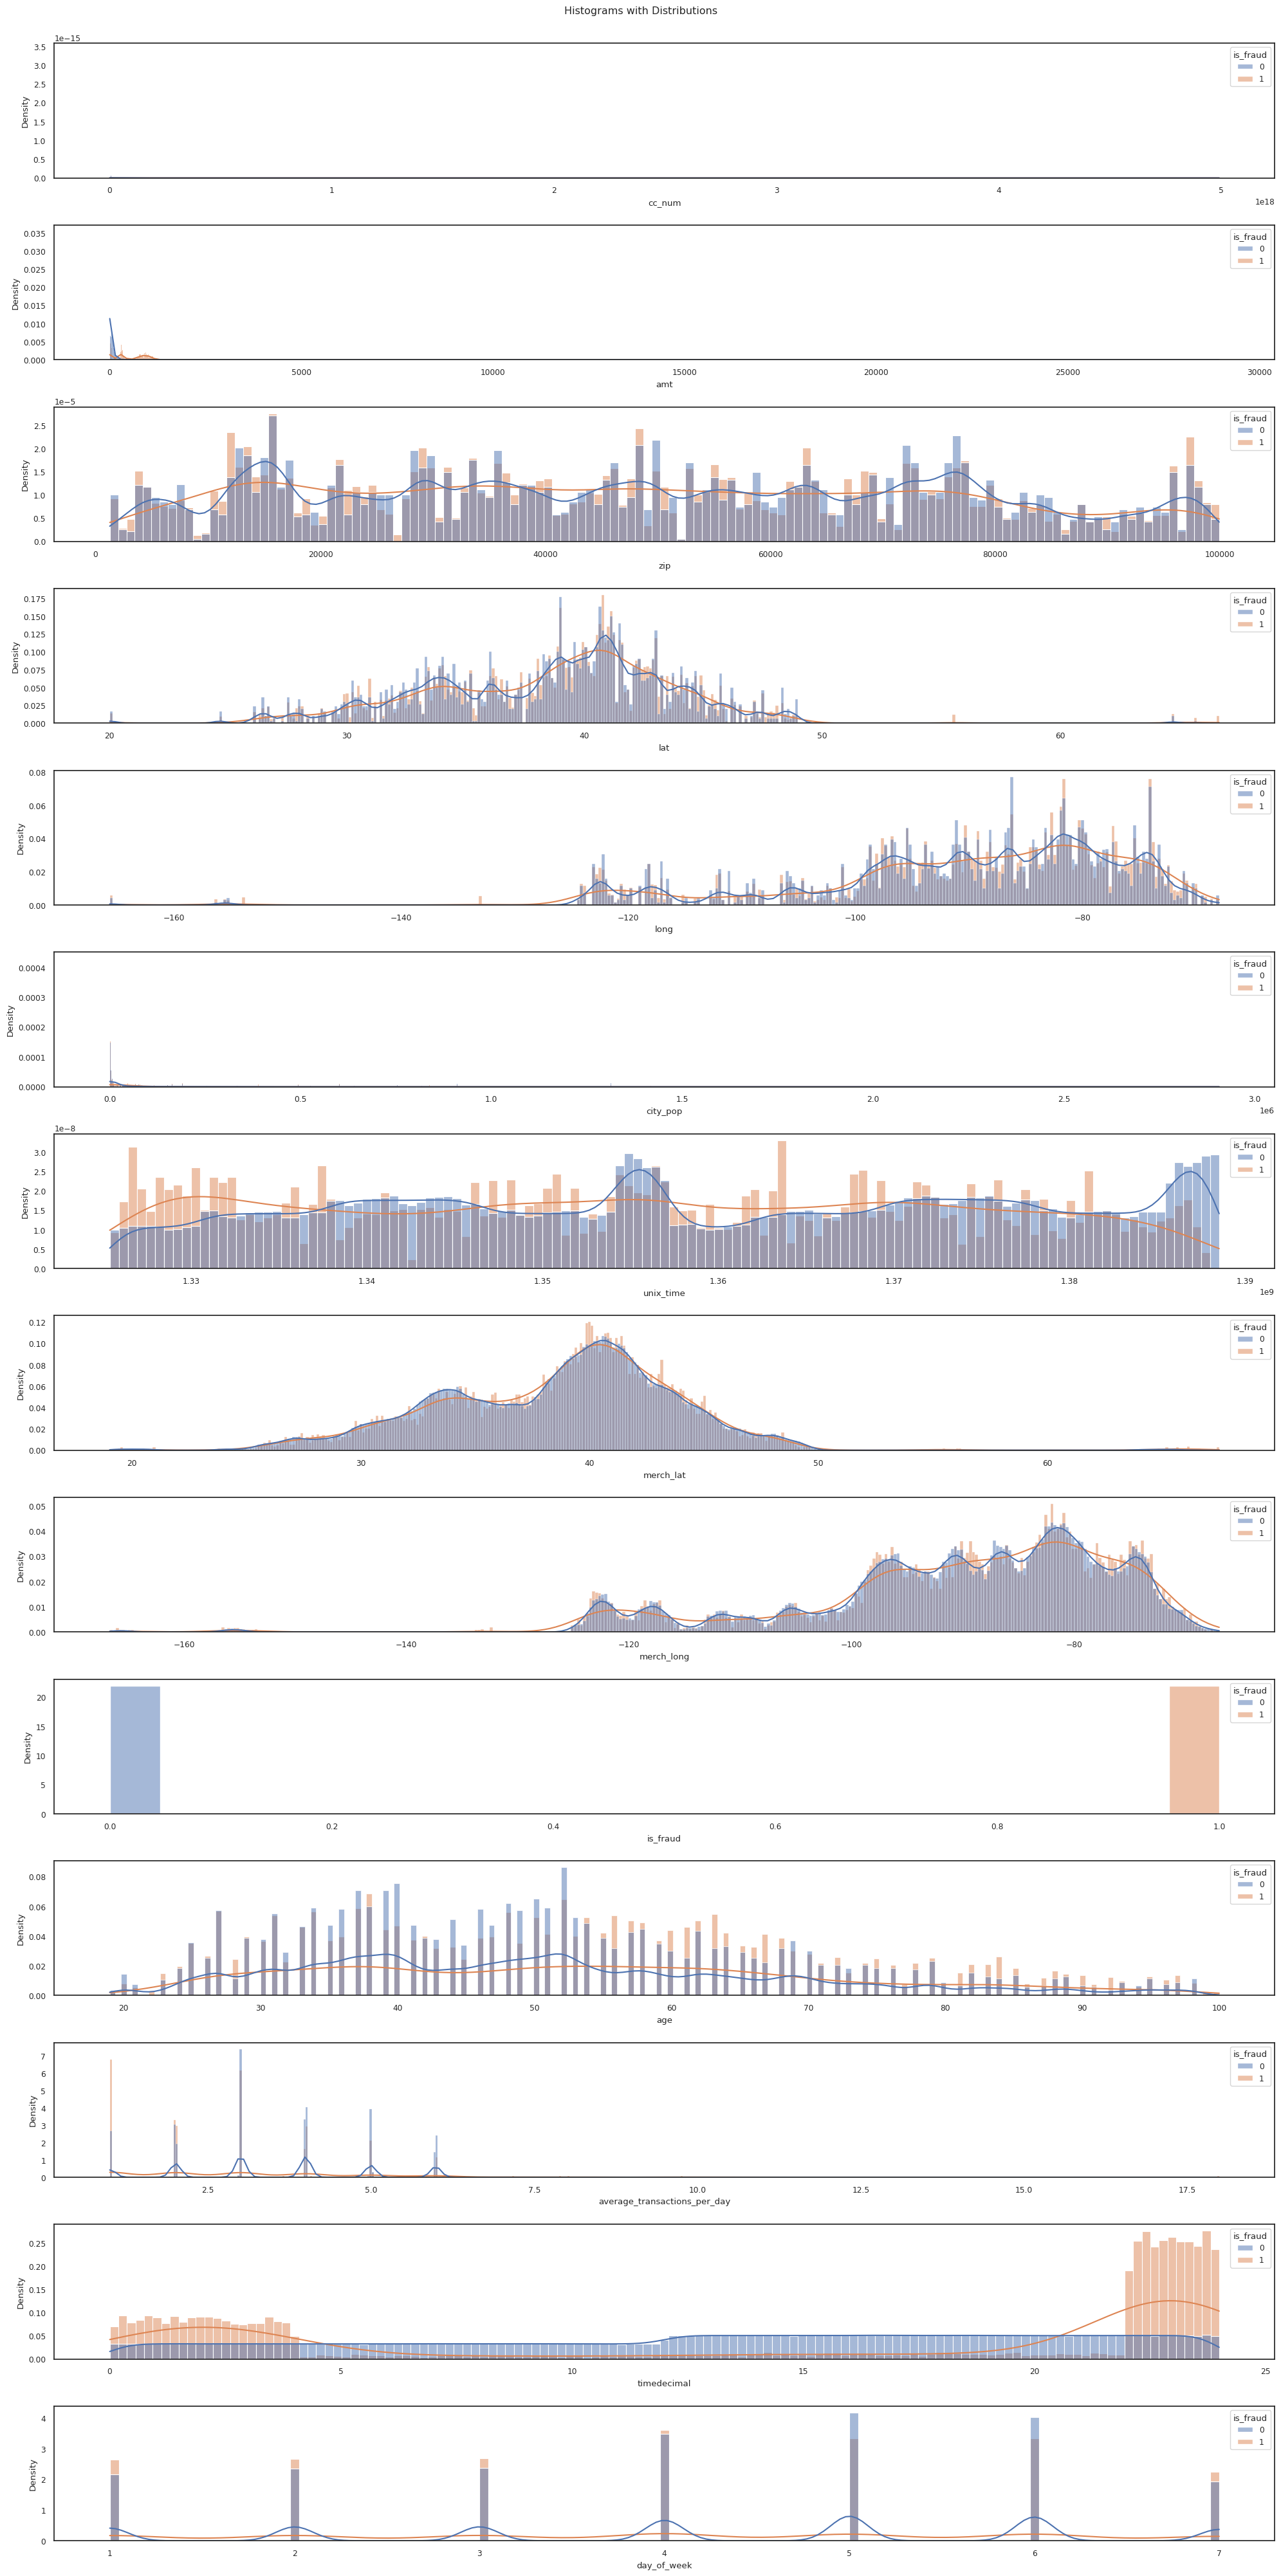

#                                                   Answers to questions


---



# Question #1



1.   What is the distribution between fraudulent and non-fraudulent transactions?

- Because of a highly imbalanced dataset, one can use following techniques - 
- oversampling of minority class by methods like SMOTE(Synthetic Minority Overssampling Technique) 
- artifically choosing equal number of rows for both classes; I ended up choosing this method
- class_weight=‘balanced’ parameter in Logistic Regression
 

The class percentage of 0 is 99.48% (Count: 1842743)
The class percentage of 1 is 0.52% (Count: 9651)


<Axes: xlabel='is_fraud', ylabel='count'>

Text(0.5, 1.0, 'Class Distribution')

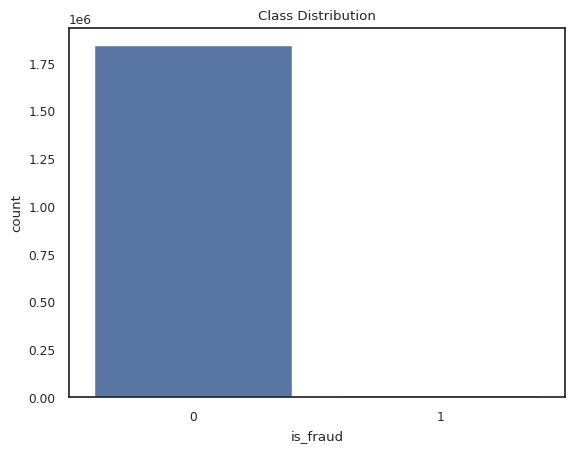

In [ ]:
class_distribution = transactions['is_fraud'].value_counts()
class_percentages = transactions['is_fraud'].value_counts(normalize=True) * 100

for class_name, count in class_distribution.items():
    percentage = class_percentages[class_name]
    print(f"The class percentage of {class_name} is {percentage:.2f}% (Count: {count})")

# chage to piechart later
sns.countplot(x='is_fraud', data=transactions)
plt.title('Class Distribution')
plt.show()
#plt.savefig("Q-1")

# Question #2

2. Which age groups are more susceptible to fraudulent transactions?
- Middle aged groups (31-70) are more susceptible. Within this group, 31-40 and 51-60 have maximum fradulent transactions. 
- Based on this information, one can bin features by age group.


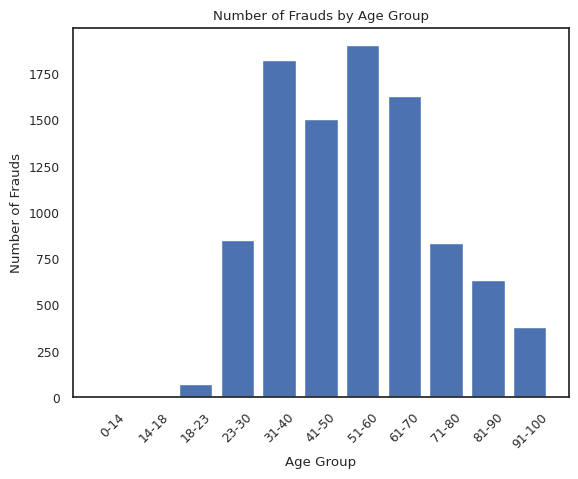

In [ ]:
# Change LABELS to cexperiment
# Step 1: Calculate age
transactions['dob'] = pd.to_datetime(transactions['dob'])  # Convert dob column to datetime
transactions['age'] = pd.Timestamp.now().year - transactions['dob'].dt.year  # Calculate age in years

# Step 2: Define age groups
age_bins = [0, 14, 18, 23, 30, 40, 50, 60, 70, 80, 90, 100]  # Define age bins
age_labels = ['0-14','14-18', '18-23', '23-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']  # Labels for age groups
transactions['age_group'] = pd.cut(transactions['age'], bins=age_bins, labels=age_labels, right=False)

# Step 3: Count the number of frauds for each age group
frauds_by_age_group = transactions[transactions['is_fraud'] == 1].groupby('age_group').size()

# Step 4: Visualize the results
plt.bar(frauds_by_age_group.index, frauds_by_age_group.values)
plt.xlabel('Age Group')
plt.ylabel('Number of Frauds')
plt.title('Number of Frauds by Age Group')
plt.xticks(rotation=45)
plt.show();

# Question #3

3. If a fraudulent transaction has been committed, what is the expected number of transaction committed per day with the same victim? (Temporal component asking do fraudulent transactions occur multiple times on the same customer)
- This histogram clearly shows frequency (~120 times) of 4-6 fraudulent transactions per day is maximum
- If a credit card is undergoing transaction at this rate, one can be suspicious of being fraudulent
- Hence, this feature can be engineered to be included in final model training
- The second histrogram shows that most of the victims suffer 1-6 fraudulent transactions per day.

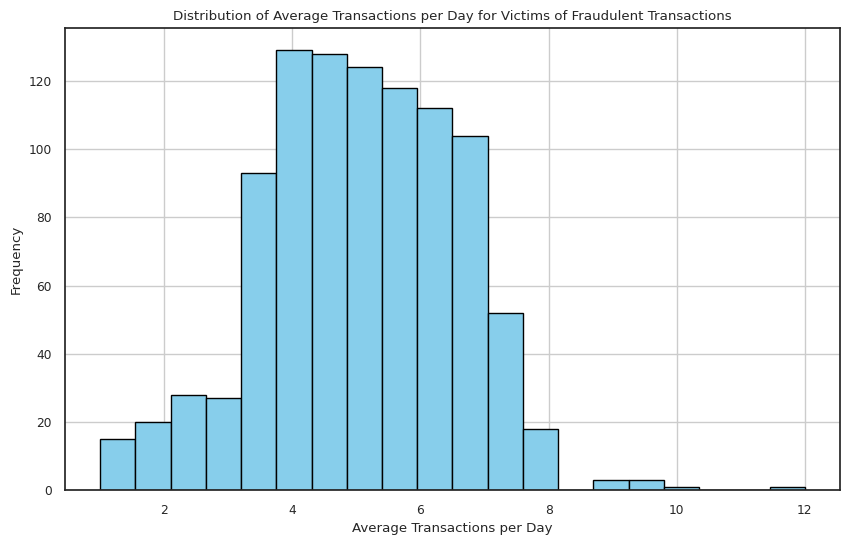

In [ ]:
# Filter to include only fraudulent transactions
fraud = transactions[transactions['is_fraud'] == 1]

# Group by victim and date of transaction, count the number of transactions per day
transactions_per_day = fraud.groupby(['victim_identifier', fraud['datetime'].dt.date]).size()

# Calculate the average number of transactions per day for each victim
average_transactions_per_day = transactions_per_day.groupby('victim_identifier').mean()

# Plot the results
plt.figure(figsize=(10, 6))
average_transactions_per_day.plot(kind='hist', bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Average Transactions per Day')
plt.ylabel('Frequency')
plt.title('Distribution of Average Transactions per Day for Victims of Fraudulent Transactions')

plt.grid(True)
plt.show();


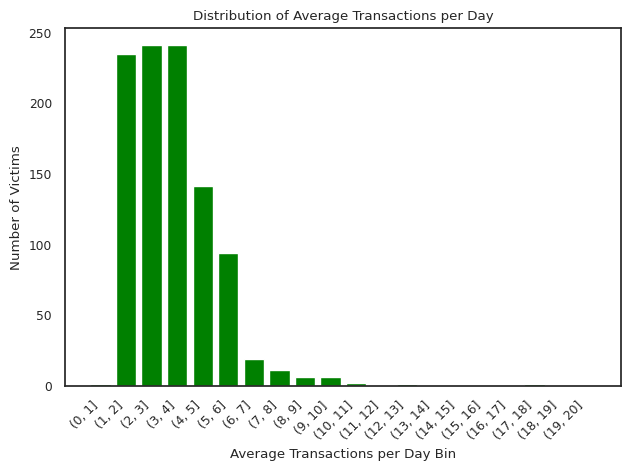

In [ ]:
# isolating rows where fraud has occured
# Isolate rows where is_fraud == 1
fraud = transactions[transactions['is_fraud'] == 1]
fraud.shape

# Concatenate first name, last name, and dob to create a unique identifier for each victim
transactions['dob'] = pd.to_datetime(transactions['dob']).dt.strftime('%Y-%m-%d')

transactions['victim_identifier'] = transactions['first'] + '_' + transactions['last'] + '_' + transactions['dob']
# Find unique victims based on the unique identifier
unique_victims = transactions['victim_identifier'].unique()

# Convert trans_date_trans_time to datetime
transactions['trans_date_trans_time'] = pd.to_datetime(transactions['trans_date_trans_time'])

# Step 1: Group by dob; each dob signifies each unique victim
grouped_by_unique_victims = transactions.groupby('victim_identifier')

# Step 2: Calculate the number of transactions for each victim
num_transactions_per_victim = grouped_by_unique_victims['trans_num'].count()

# Step 3: Calculate the time span (in days) between the earliest and latest transactions for each victim
time_span_per_victim = grouped_by_unique_victims['trans_date_trans_time'].apply(lambda x: (x.max() - x.min()) / pd.Timedelta(days=1))

# Step 4: Calculate the average number of transactions per day for each victim
average_transactions_per_day = num_transactions_per_victim / time_span_per_victim

## Step 5: Add the new column 'average_transactions_per_day' to the original DataFrame
transactions['average_transactions_per_day'] = grouped_by_unique_victims['trans_num'].transform(lambda x: x.count()) / grouped_by_unique_victims['trans_date_trans_time'].transform(lambda x: (x.max() - x.min()) / pd.Timedelta(days=1))

# Binning strategy
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Assign bin values based on 'average_transactions_per_day'
transactions['bin'] = pd.cut(transactions['average_transactions_per_day'], bins=bins, labels=range(1, len(bins)))

average_transactions = pd.DataFrame({'average_transactions_per_day': average_transactions_per_day})

# Bin the average transactions per day
average_transactions['bin'] = pd.cut(average_transactions['average_transactions_per_day'], bins=bins)
# Count how many average transactions fall into each bin
transactions_per_bin = average_transactions['bin'].value_counts().sort_index()

# Plotting histogram
plt.bar(transactions_per_bin.index.astype(str), transactions_per_bin.values, color='green')
plt.xlabel('Average Transactions per Day Bin')
plt.ylabel('Number of Victims')
plt.title('Distribution of Average Transactions per Day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();


# Question #4

4. For each purchase "category," plot the mean and standard "amt" between fraudulent transactions and non-fraudulent transactions
- This data analysis only reveals that travel category is the most susceptible. I did not include this feature in my final analysis.

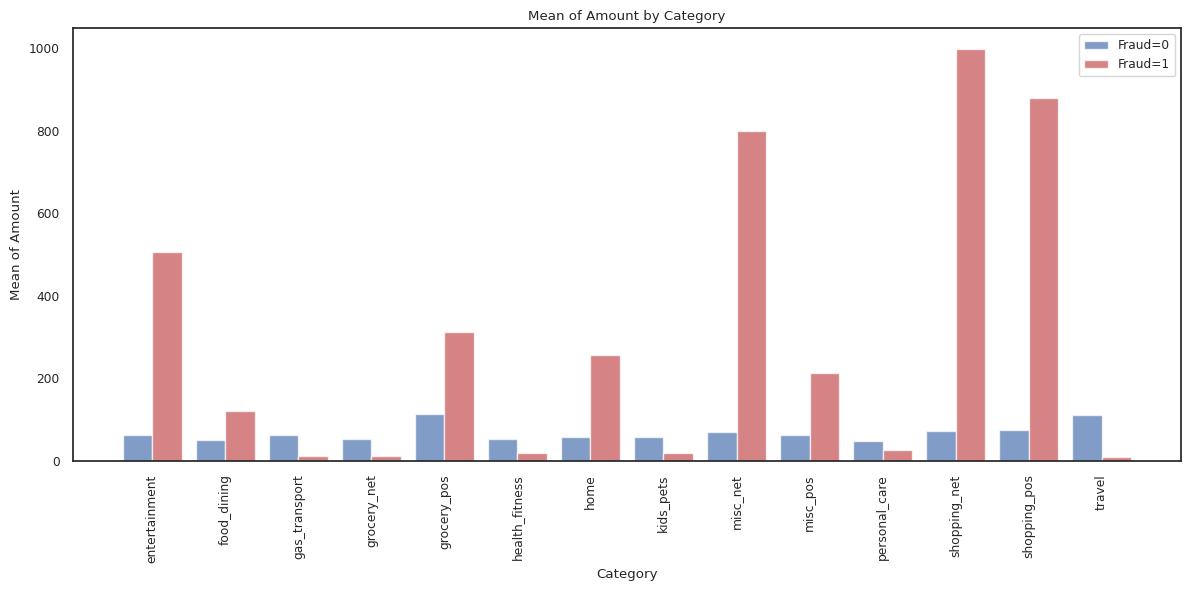

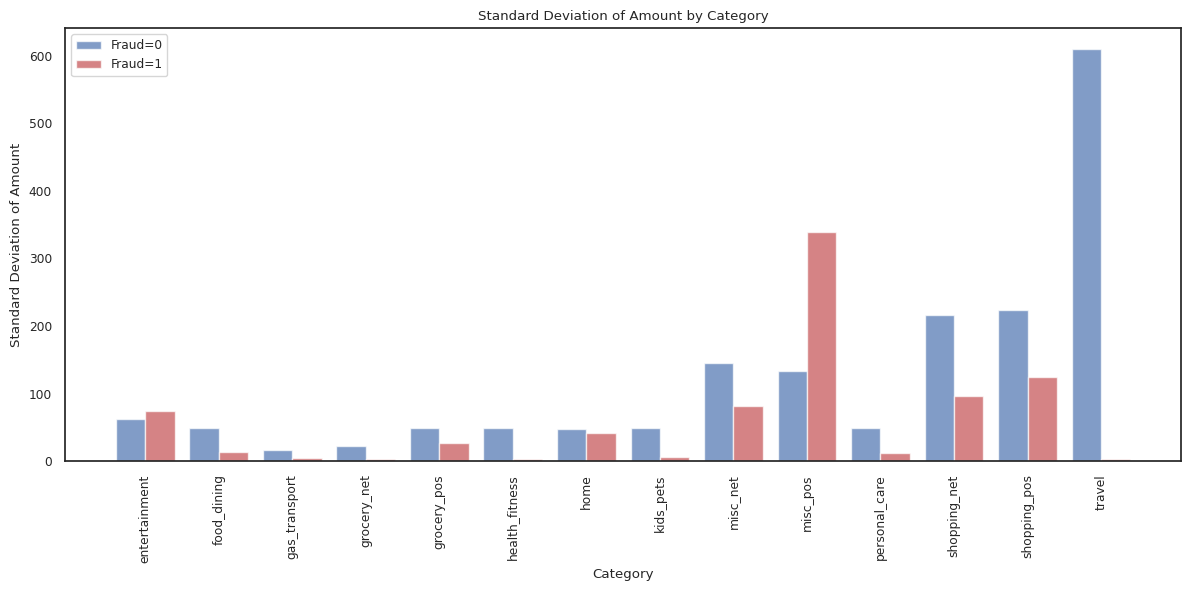

In [ ]:
import matplotlib.pyplot as plt
mean_df = transactions.groupby(['category', 'is_fraud']).amt.mean().reset_index()
stdev_df = transactions.groupby(['category', 'is_fraud']).amt.std().reset_index()

# Plotting mean
plt.figure(figsize=(12, 6))

# Separate mean values for fraud and non-fraud transactions
mean_fraud_0 = mean_df[mean_df['is_fraud'] == 0]
mean_fraud_1 = mean_df[mean_df['is_fraud'] == 1]

# Plotting means for fraud=0
plt.bar(np.arange(len(mean_fraud_0['category'])) - 0.2, mean_fraud_0['amt'], width=0.4, alpha=0.7, color='b', label='Fraud=0')

# Plotting means for fraud=1
plt.bar(np.arange(len(mean_fraud_1['category'])) + 0.2, mean_fraud_1['amt'], width=0.4, alpha=0.7, color='r', label='Fraud=1')

plt.xlabel('Category')
plt.ylabel('Mean of Amount')
plt.title('Mean of Amount by Category')
plt.xticks(np.arange(len(mean_fraud_0['category'])), mean_fraud_0['category'], rotation=90)
plt.legend()
plt.tight_layout()

plt.show()

# Plotting standard deviation
plt.figure(figsize=(12, 6))

# Separate standard deviation values for fraud and non-fraud transactions
stdev_fraud_0 = stdev_df[stdev_df['is_fraud'] == 0]
stdev_fraud_1 = stdev_df[stdev_df['is_fraud'] == 1]

# Plotting standard deviation for fraud=0
plt.bar(np.arange(len(stdev_fraud_0['category'])) - 0.2, stdev_fraud_0['amt'], width=0.4, alpha=0.7, color='b', label='Fraud=0')

# Plotting standard deviation for fraud=1
plt.bar(np.arange(len(stdev_fraud_1['category'])) + 0.2, stdev_fraud_1['amt'], width=0.4, alpha=0.7, color='r', label='Fraud=1')

plt.xlabel('Category')
plt.ylabel('Standard Deviation of Amount')
plt.title('Standard Deviation of Amount by Category')
plt.xticks(np.arange(len(stdev_fraud_0['category'])), stdev_fraud_0['category'], rotation=45)
plt.legend()
plt.tight_layout()

plt.show();

# focus on amounts, as it turns out, can separate frauds from legitimate

# Question #5

5. What is the distribution between time transactions between fraudulent transactions and non-fraudulent transactions? What is the most likely time of a fraudulent transaction?
- This was a very important way to classify transaction. As can be seen from the plot, majority of the fraudulent transactions happen between 10pm-4am
- I engineered a feature called 'is_night' to leverage this observation. I assigned 0 to transactions that dont occur in 10pm-4am slot and 1 to those occur between 10pm-4am

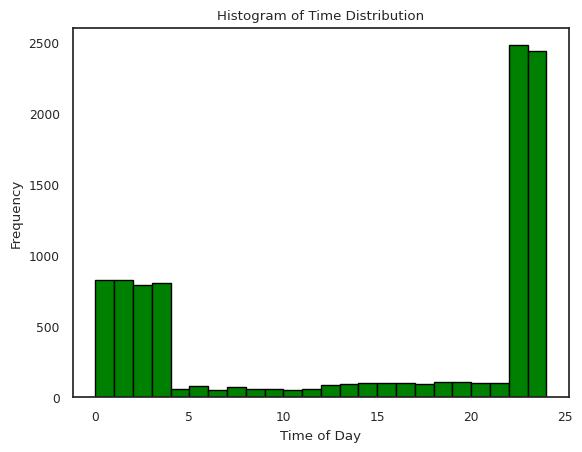

In [ ]:
import matplotlib.dates as mdates
transactions['time'] = pd.to_datetime(transactions['trans_date_trans_time']).dt.time

#Convert time to a number (e.g., hours + minutes/60 + seconds/3600)
transactions['timedecimal'] = transactions['time'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

newdata = transactions[transactions['is_fraud'] == 1]
# Plot histogram
plt.hist(newdata['timedecimal'], bins=24, range=(0,24), color='green', edgecolor='black')  # 24 bins for 24 hours

# Format x-axis to show hours

plt.xlabel('Time of Day')
plt.ylabel('Frequency')
plt.title('Histogram of Time Distribution')

plt.show();
# Fraud happening mainly at night

# Question #6

6. Is there a relationship between the distance between customer location (lat/lon) and merchant location (merch_lat/merch_lon) and fraudulent transactions?
- There is no relationship between the distance between customer location (lat/lon) and merchant location (merch_lat/merch_lon) and fraudulent transactions. The location overlay over each other and dont show any patterns. I did not include this feature for modeling.

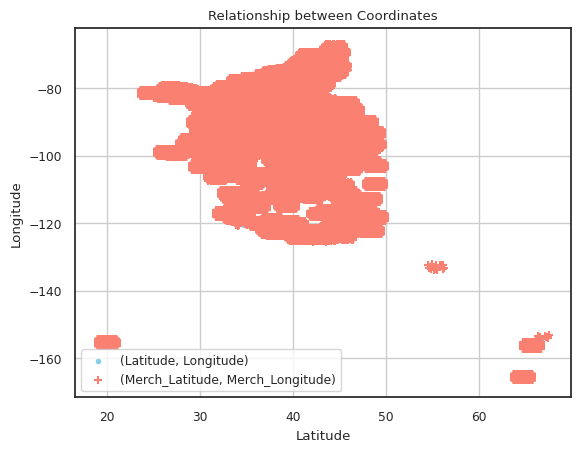

In [ ]:
import matplotlib.pyplot as plt

# Plotting (latitude, longitude) pairs
plt.scatter(transactions['lat'], transactions['long'], color='skyblue', label='(Latitude, Longitude)', marker='.')

# Plotting (merch_lat, merch_long) pairs with a lighter shade of red
plt.scatter(transactions['merch_lat'], transactions['merch_long'], color='salmon', label='(Merch_Latitude, Merch_Longitude)', marker='+')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Relationship between Coordinates')
plt.legend()
plt.grid(True)

plt.show();



# Question #7

7. Are certain states, cities, and zip codes more susceptible to fraudulent transactions?
- From the analysis, it doesnt seem that geographic locations have any impact. Hence, I ignored these features.

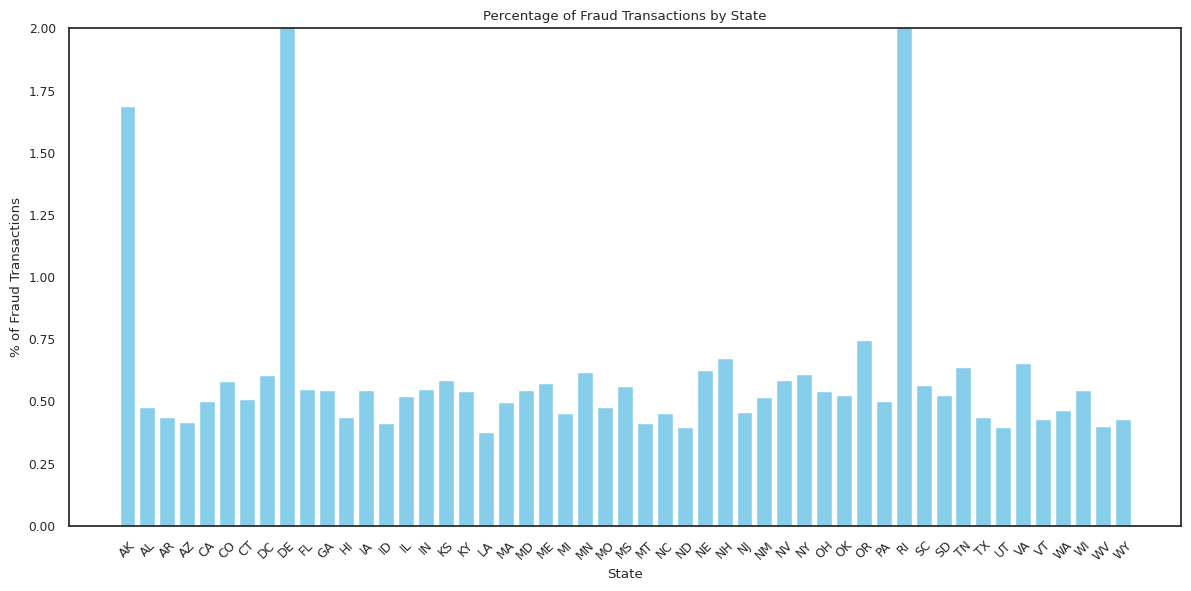

In [ ]:
# may not be necessary as longitude and latidtude locations might cover up
# although show, which geographical locations comes out to
# maybe use locations once grouping has done by customers
#fraud.head()

# Calculate the percentage of fraud transactions for each state
fraud_percentage = transactions.groupby('state')['is_fraud'].mean() * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(fraud_percentage.index, fraud_percentage.values, color='skyblue')
plt.xlabel('State')
plt.ylabel('% of Fraud Transactions')
plt.title('Percentage of Fraud Transactions by State')
plt.xticks(rotation=45)
plt.ylim(0, 2)
plt.tight_layout()

plt.show();

# Delaware shows 100% !

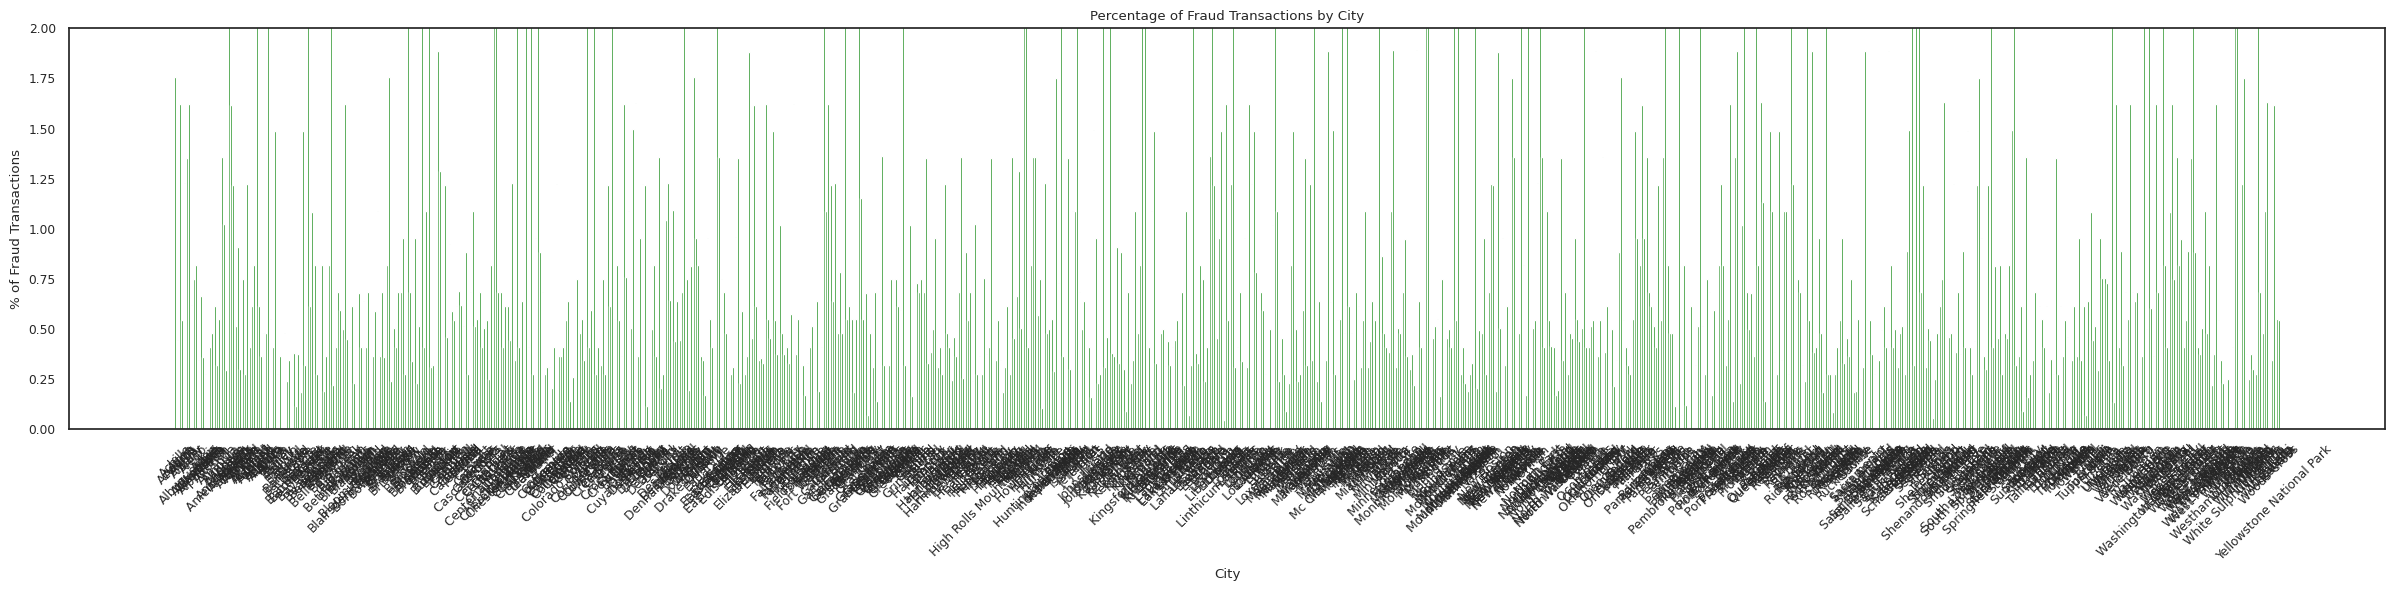

In [ ]:
# Calculate the percentage of fraud transactions for each city
fraud_percentage = transactions.groupby('city')['is_fraud'].mean() * 100

# Plotting
plt.figure(figsize=(24, 6))
plt.bar(fraud_percentage.index, fraud_percentage.values, color='green')
plt.xlabel('City')
plt.ylabel('% of Fraud Transactions')
plt.title('Percentage of Fraud Transactions by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0, 2)
plt.show();



# Question #8

8. What is the distribution of fraudulent and non-fraudulent transactions occurring for each day of the week (i.e., Sunday, Monday, etc.), each month of the year (i.e., January, February)?
- The distribution seems fairly uniform but thursdays, fridays, saturdays, march and may showing maximum fraud transactions. 
- I didnt use these features.

In [ ]:
transactions.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'sex', 'street', 'city', 'state', 'zip', 'lat', 'long',
       'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'age', 'age_group', 'victim_identifier',
       'average_transactions_per_day', 'bin', 'time', 'timedecimal'],
      dtype='object')

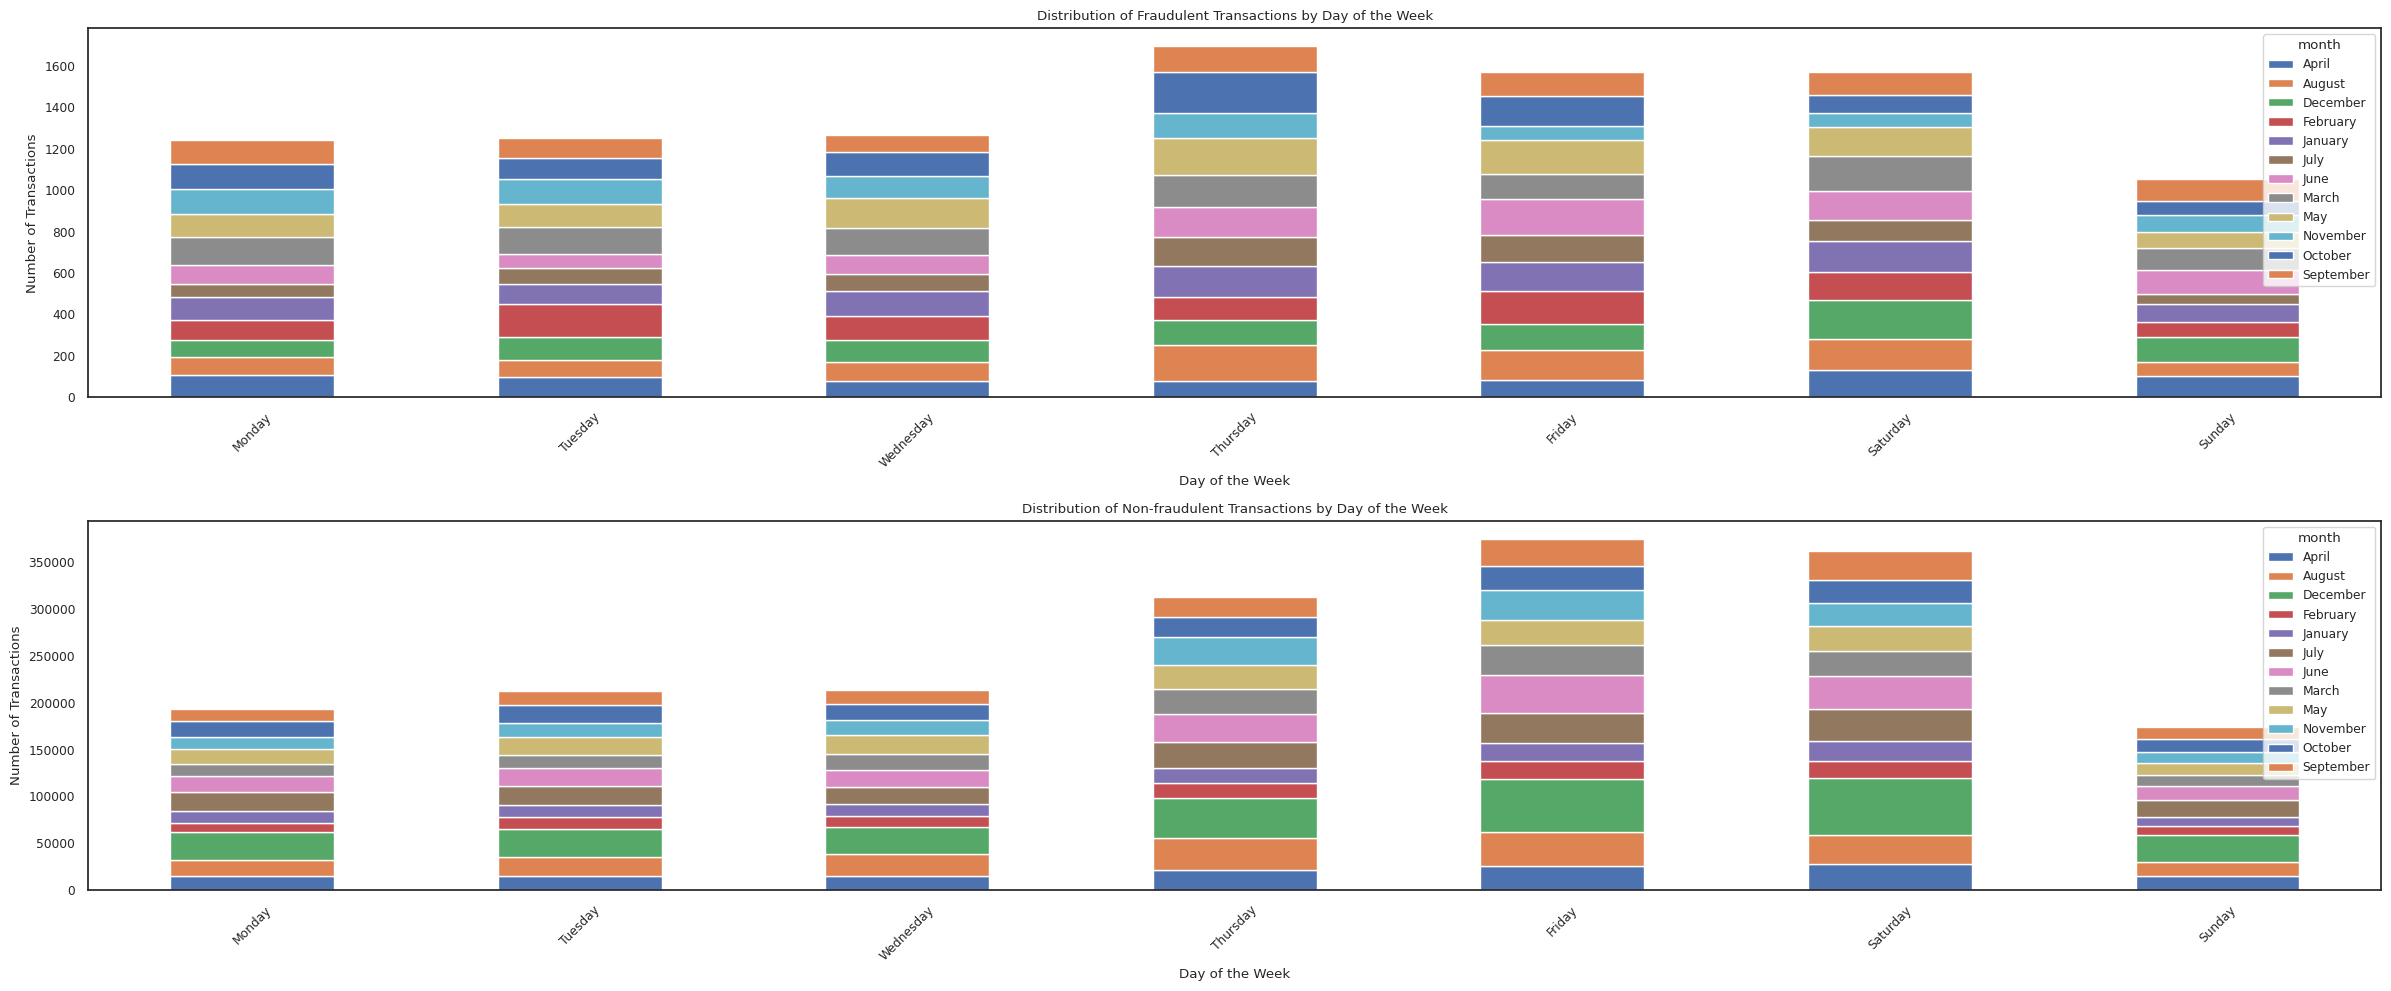

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Unix timestamp to datetime object
transactions['datetime'] = pd.to_datetime(transactions['unix_time'], unit='s')

# Extract day of the week (Sunday=0, Monday=1, ..., Saturday=6)
transactions['day_of_week'] = transactions['datetime'].dt.dayofweek
# Map the day of the week to start from Monday=1 to Sunday=7
transactions['day_of_week'] = transactions['day_of_week'].map({0: 7, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6})

# Extract month of the year
transactions['month'] = transactions['datetime'].dt.month_name()

# Group by day of the week and month, and count occurrences of fraudulent and non-fraudulent transactions
fraudulent_counts = transactions[transactions['is_fraud'] == 1].groupby(['day_of_week', 'month']).size()
non_fraudulent_counts = transactions[transactions['is_fraud'] == 0].groupby(['day_of_week', 'month']).size()

# Plot distributions
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 10))

# Fraudulent transactions by day of the week
fraudulent_counts.unstack().plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of Fraudulent Transactions by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)

# Non-fraudulent transactions by day of the week
non_fraudulent_counts.unstack().plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Distribution of Non-fraudulent Transactions by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Number of Transactions')
axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)

plt.tight_layout()
plt.show();


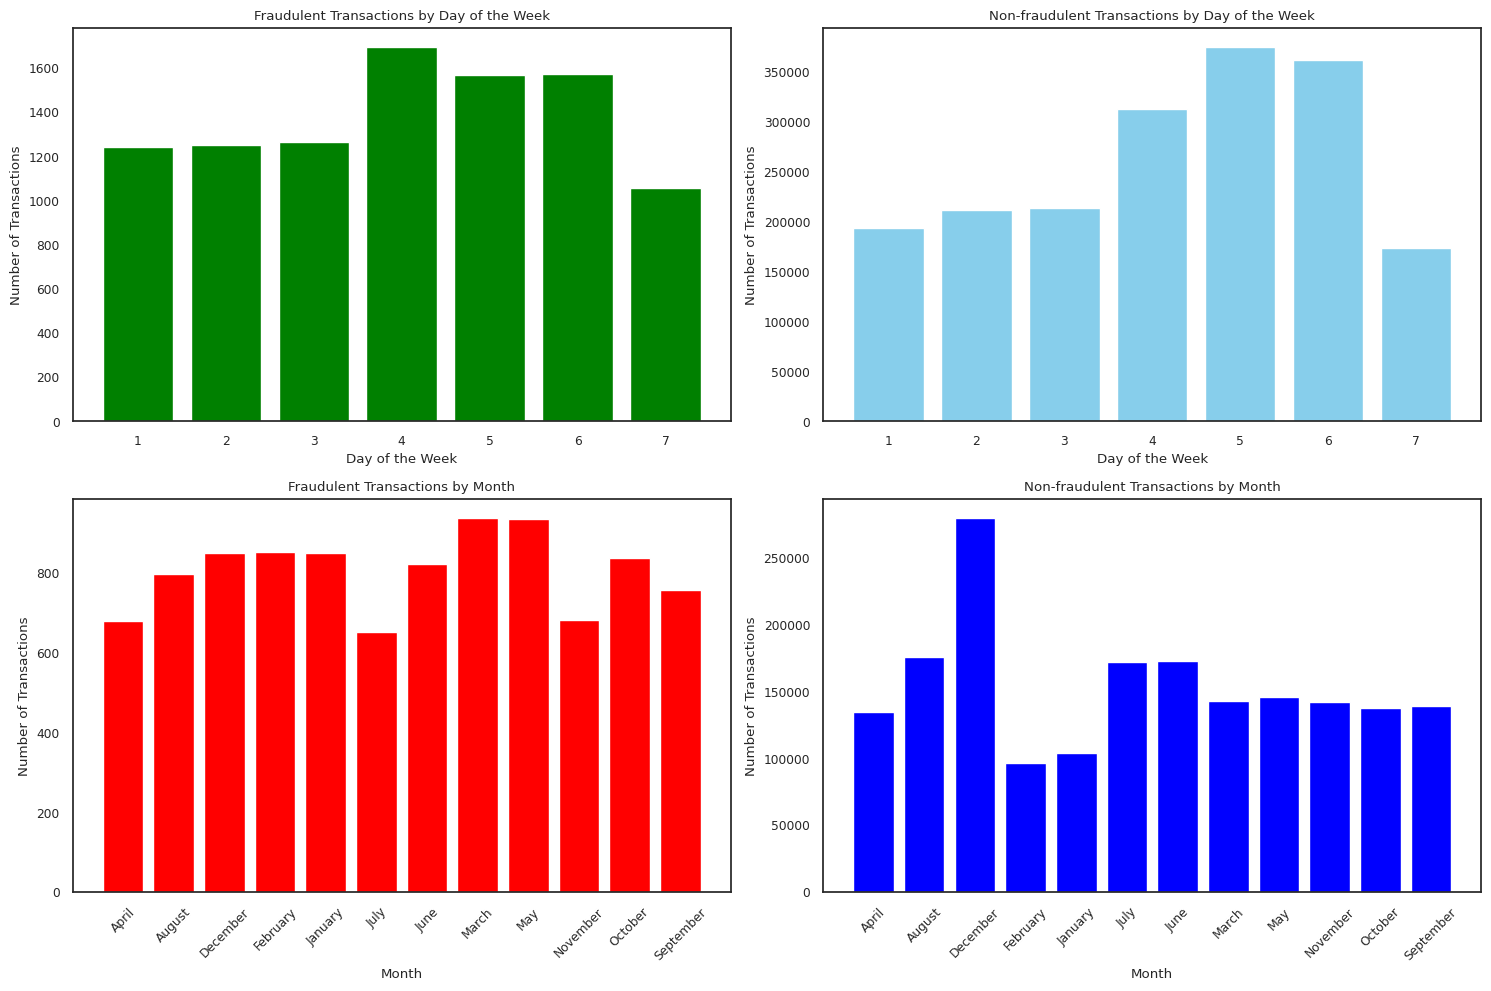

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Unix timestamp to datetime object
transactions['datetime'] = pd.to_datetime(transactions['unix_time'], unit='s')

# Extract day of the week (Sunday=0, Monday=1, ..., Saturday=6)
transactions['day_of_week'] = transactions['datetime'].dt.dayofweek
# Map the day of the week to start from Monday=1 to Sunday=7
transactions['day_of_week'] = transactions['day_of_week'].map({0: 7, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6})

# Extract month of the year
transactions['month'] = transactions['datetime'].dt.month_name()

# Group by day of the week and month, and count occurrences of fraudulent and non-fraudulent transactions
fraudulent_counts_day = transactions[transactions['is_fraud'] == 1].groupby(['day_of_week']).size()
non_fraudulent_counts_day = transactions[transactions['is_fraud'] == 0].groupby(['day_of_week']).size()

fraudulent_counts_month = transactions[transactions['is_fraud'] == 1].groupby(['month']).size()
non_fraudulent_counts_month = transactions[transactions['is_fraud'] == 0].groupby(['month']).size()

# Plot distributions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot for fraudulent transactions by day of the week
axes[0, 0].bar(fraudulent_counts_day.index, fraudulent_counts_day, color='green')
axes[0, 0].set_title('Fraudulent Transactions by Day of the Week')
axes[0, 0].set_xlabel('Day of the Week')
axes[0, 0].set_ylabel('Number of Transactions')

# Plot for non-fraudulent transactions by day of the week
axes[0, 1].bar(non_fraudulent_counts_day.index, non_fraudulent_counts_day, color='skyblue')
axes[0, 1].set_title('Non-fraudulent Transactions by Day of the Week')
axes[0, 1].set_xlabel('Day of the Week')
axes[0, 1].set_ylabel('Number of Transactions')

# Plot for fraudulent transactions by month
axes[1, 0].bar(fraudulent_counts_month.index, fraudulent_counts_month, color='red')
axes[1, 0].set_title('Fraudulent Transactions by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot for non-fraudulent transactions by month
axes[1, 1].bar(non_fraudulent_counts_month.index, non_fraudulent_counts_month, color='blue')
axes[1, 1].set_title('Non-fraudulent Transactions by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show();


In [ ]:
# plot transaction counts Vs Days/Months
def transform(df):
  df['trans_date_trans_time'] = pd.to_dateline(df['trans_date_trans_time'])

  df['Day of week'] = df['trans_date_trans_time'].dt.day_name()
  df['Month'] = df['trans_date_trans_time'].dt.month_name()



# Question: 9

9. Compared to any other time of the year, how prevalent are fraudulent transactions during the holidays (11-30 to 12-31)? During post-holidays (1-1 to 2-28)? During the summer (05-24 to 09-01)?
- This data clearly shows a pattern
- The three time periods clearly have most fraud transactions
- I used this information to engineer a feature called 'is_months'. I assigned 1 to transactions happening in these months and 0 to those happening in other months.

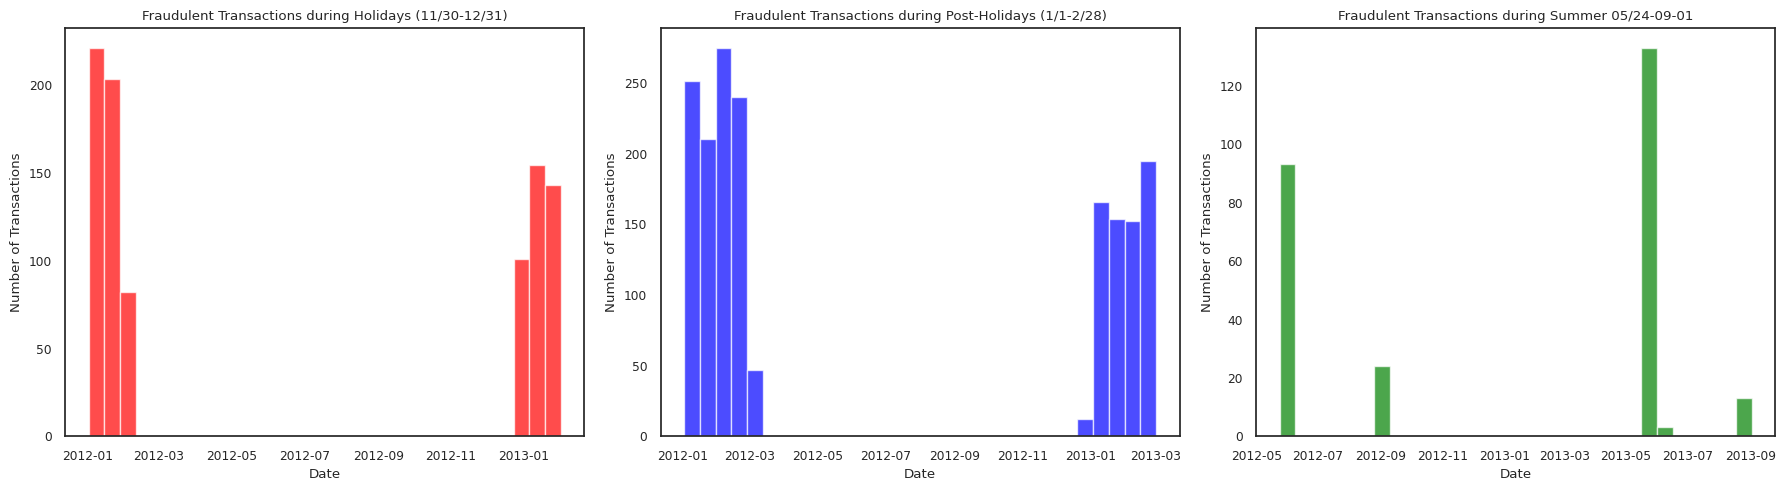

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Unix timestamp to datetime object
transactions['datetime'] = pd.to_datetime(transactions['unix_time'], unit='s')

# Define boolean masks for each period
holidays_mask = ((transactions['datetime'].dt.month == 12) & (transactions['datetime'].dt.day >= 30)) | \
                ((transactions['datetime'].dt.month == 1) & (transactions['datetime'].dt.day <= 31))
post_holidays_mask = (transactions['datetime'].dt.month == 1) | (transactions['datetime'].dt.month == 2)
summer_mask = (transactions['datetime'].dt.month >= 5) & (transactions['datetime'].dt.month <= 9) & \
              ((transactions['datetime'].dt.month == 5) & (transactions['datetime'].dt.day >= 24) |
               (transactions['datetime'].dt.month == 9) & (transactions['datetime'].dt.day <= 1))

# Filter fraudulent transactions for each period
holidays_fraudulent = transactions[(transactions['is_fraud'] == 1) & holidays_mask]
post_holidays_fraudulent = transactions[(transactions['is_fraud'] == 1) & post_holidays_mask]
summer_fraudulent = transactions[(transactions['is_fraud'] == 1) & summer_mask]

# Plot distributions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot for fraudulent transactions during holidays
axes[0].hist(holidays_fraudulent['datetime'], bins=30, color='red', alpha=0.7)
axes[0].set_title('Fraudulent Transactions during Holidays (11/30-12/31)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Transactions')

# Plot for fraudulent transactions during post-holidays
axes[1].hist(post_holidays_fraudulent['datetime'], bins=30, color='blue', alpha=0.7)
axes[1].set_title('Fraudulent Transactions during Post-Holidays (1/1-2/28)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Transactions')

# Plot for fraudulent transactions during summer
axes[2].hist(summer_fraudulent['datetime'], bins=30, color='green', alpha=0.7)
axes[2].set_title('Fraudulent Transactions during Summer 05/24-09-01')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show();


# Question: 10

10. Is there a relationship between between "city_pop" and incidence of fraud?
- No there is no relationship !

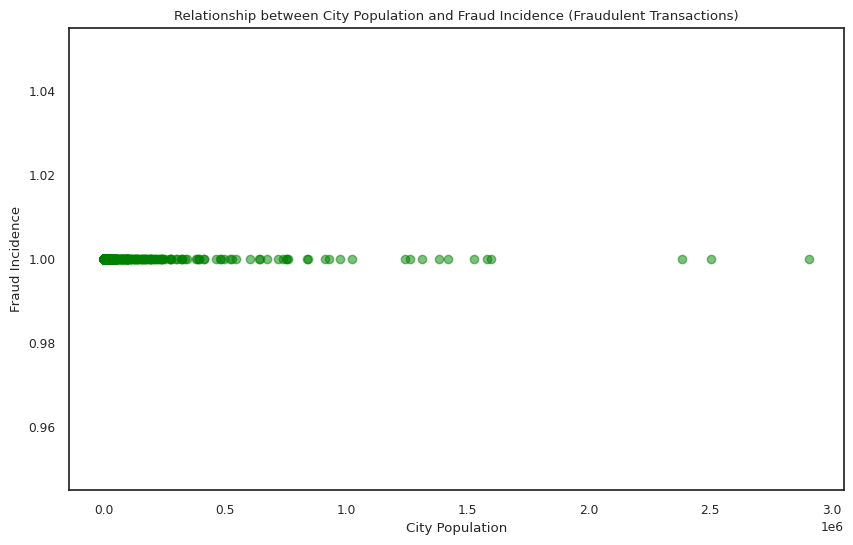

In [ ]:
import matplotlib.pyplot as plt

# Filter rows where 'is_fraud' is equal to 1
fraudulent_transactions = transactions[transactions['is_fraud'] == 1]

# Group by city and calculate the mean fraud incidence for each city
city_fraud_incidence = fraudulent_transactions.groupby('city_pop')['is_fraud'].mean()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(city_fraud_incidence.index, city_fraud_incidence.values, color='green', alpha=0.5)

# Set labels and title
plt.xlabel('City Population')
plt.ylabel('Fraud Incidence')
plt.title('Relationship between City Population and Fraud Incidence (Fraudulent Transactions)')

plt.show();


# Question #11

11. Are certain "job" types susceptible to fraudulent transactions?
- Yes there is a trend but I did not use this feature. I could have split the job types in two categories - those facing above 30 fraudulent transactions and those facing below 30.

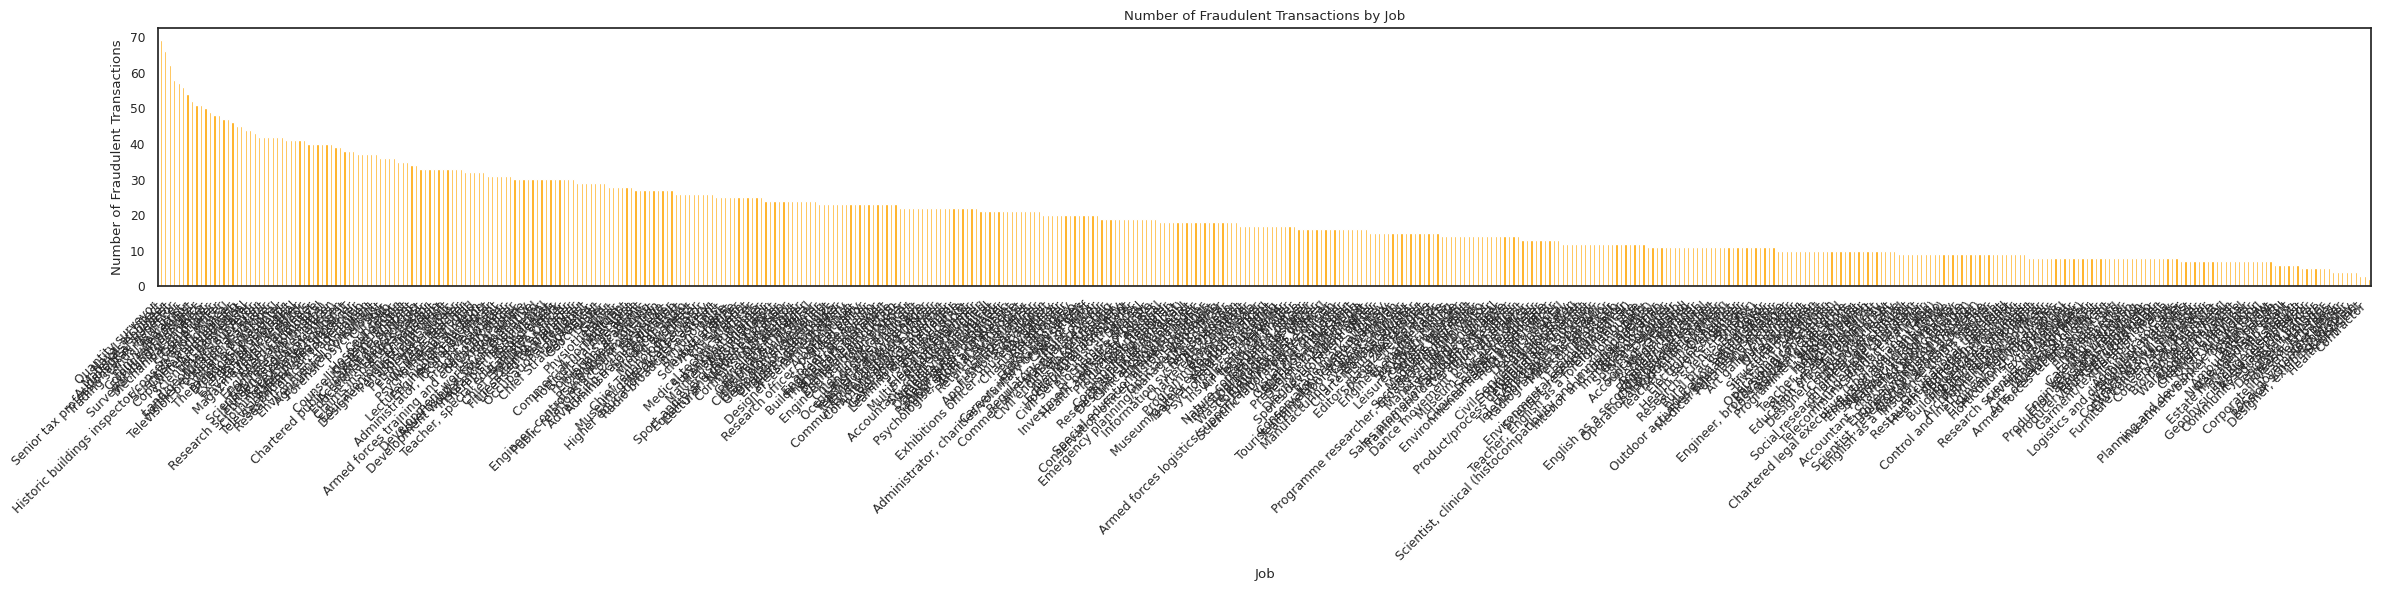

In [ ]:
# Group by 'job' and count the number of fraudulent transactions for each job
fraudulent_job_counts = fraud['job'].value_counts()

# Create a bar plot
plt.figure(figsize=(24, 6))
fraudulent_job_counts.plot(kind='bar', color='orange')

# Set labels and title
plt.xlabel('Job')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Number of Fraudulent Transactions by Job')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show();


12. Think of at least 4 more questions and provide the answers to them.

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Time Difference between Fraudulent Transactions')

Text(0, 0.5, 'Number of Fraudulent Transactions')

Text(0.5, 1.0, 'Duration between Fraudulent Transactions and Number of Transactions')

(0.0, 100000.0)

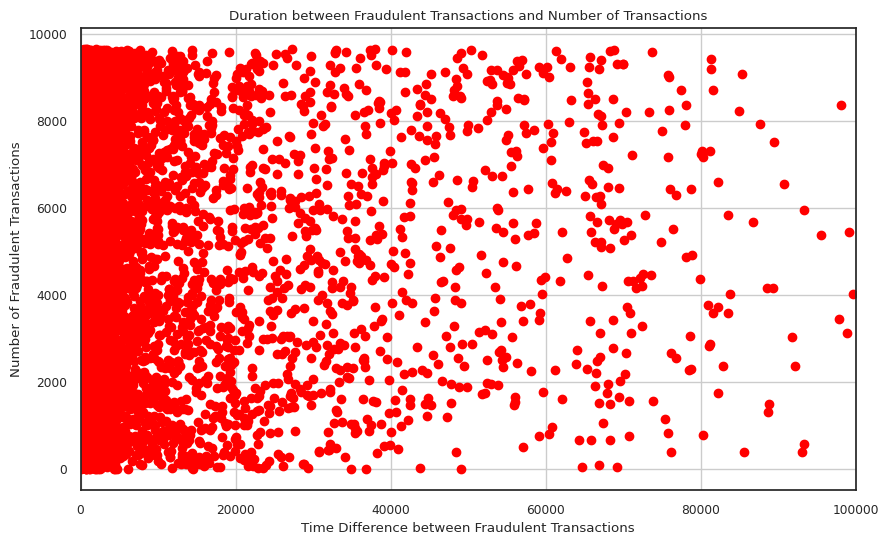

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'transactions' is your DataFrame and 'unix_time' is the column representing the transaction timestamp

# Filter to include only fraudulent transactions
fraudulent_transactions = transactions[transactions['is_fraud'] == 1]

# Sort the DataFrame by transaction timestamp
fraudulent_transactions = fraudulent_transactions.sort_values(by='unix_time')

# Calculate the time differences between consecutive fraudulent transactions
fraudulent_transactions['time_diff'] = fraudulent_transactions['unix_time'].diff().fillna(0)

# Plot the distribution of time differences and the corresponding number of transactions
plt.figure(figsize=(10, 6))
plt.scatter(fraudulent_transactions['time_diff'], range(1, len(fraudulent_transactions) + 1), color='red')
plt.xlabel('Time Difference between Fraudulent Transactions')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Duration between Fraudulent Transactions and Number of Transactions')
plt.xlim(0, 100000)
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Time Difference between Non-Fraudulent Transactions')

Text(0, 0.5, 'Number of Non-Fraudulent Transactions')

Text(0.5, 1.0, 'Duration between Non-Fraudulent Transactions and Number of Transactions')

(0.0, 100000.0)

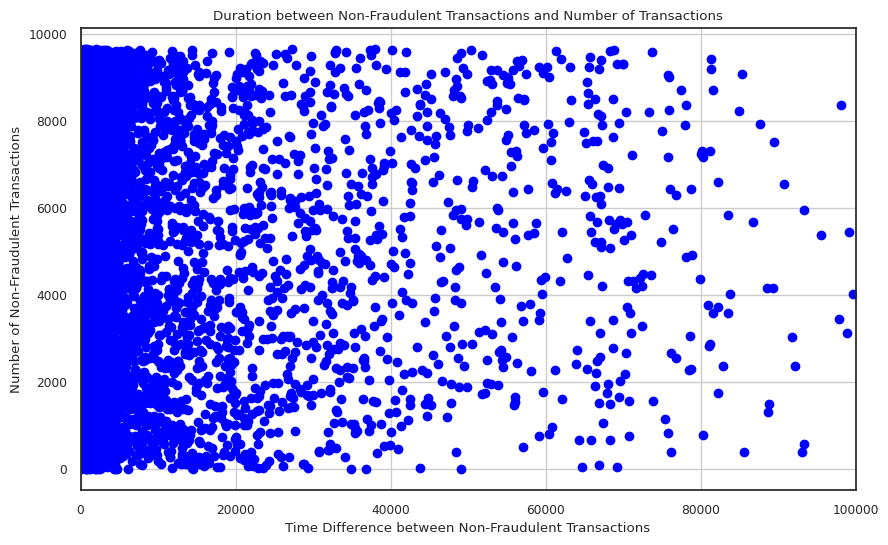

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'transactions' is your DataFrame and 'unix_time' is the column representing the transaction timestamp

# Filter to include only fraudulent transactions
nonfraudulent_transactions = transactions[transactions['is_fraud'] == 0]

# Sort the DataFrame by transaction timestamp
nonfraudulent_transactions = nonfraudulent_transactions.sort_values(by='unix_time')

# Calculate the time differences between consecutive fraudulent transactions
nonfraudulent_transactions['time_diff'] = nonfraudulent_transactions['unix_time'].diff().fillna(0)

# Plot the distribution of time differences and the corresponding number of transactions
plt.figure(figsize=(10, 6))
plt.scatter(fraudulent_transactions['time_diff'], range(1, len(fraudulent_transactions) + 1), color='blue')
plt.xlabel('Time Difference between Non-Fraudulent Transactions')
plt.ylabel('Number of Non-Fraudulent Transactions')
plt.title('Duration between Non-Fraudulent Transactions and Number of Transactions')
plt.xlim(0, 100000)
plt.grid(True)
plt.show()
